## Soma Analysis

Data: the somas being analysed here were manually selected by Kathleen and called usign Soma caller by Aashir. 

Objective: compare binary called barcode distribution, collisions, length to full neurite volume of predicted binary calls. 

## Defining functions for soma analysis

In [2]:
import zarr #open files
import sklearn.metrics as sn
from sklearn.decomposition import PCA 
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance

import math
import os
import textwrap
from adjustText import adjust_text
from itertools import combinations
import datetime

# colab specific -- mount drive
# drive.mount('/content/drive'

# seaborn and defaults

## seaborn settings
e11_color = '#005787'
e11_bright = "#26BFF2"
date_str = datetime.datetime.now().strftime('%y%m%d')

sns.set_theme(context='notebook', style='darkgrid')

## helper function to break titles normally
def break_title(title, figsize, min_line_width=20, avg_char_width=0.2):
    
    """
    Break a title into lines with a specified maximum width to fit in a plot.

    Parameters:
        title (str): The title to be broken into lines.
        figsize (tuple): Tuple representing the width and height of the plot.
        max_line_width (int): Maximum width of each line in characters.
        avg_char_width (float): Average width of a character in inches.

    Returns:
        str: Title text with line breaks.
    """
    plot_width, plot_height = figsize

    # Calculate the maximum number of characters per line
    max_chars_per_line = max(min_line_width, int(plot_width / avg_char_width))

    # Break the title into lines with maximum width
    broken_title = textwrap.fill(title, width=max_chars_per_line)

    return broken_title


def generate_export_title(user_string, sample_id, date_str = date_str, output_type = 'png'):
    # Get the current date and format it as YYMMDD
    if date_str is None:
        date_str = datetime.datetime.now().strftime('%y%m%d')
    
    # Create the title string by combining user string, sample ID, and formatted date
    title = f"{date_str}_{sample_id}_{user_string}.{output_type}"
    return title


def annotate_bars(ax=None, fmt='.2f', **kwargs):
    ax = plt.gca() if ax is None else ax
    for p in ax.patches:
         ax.annotate('{{:{:s}}}'.format(fmt).format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                     xytext=(0, 5),textcoords='offset points',
                     ha='center', va='center', **kwargs)



def import_zarr(file):
    vals = zarr.open(file, mode="r")
    df = pd.DataFrame({'coords': vals['coords'][:].tolist(),
                   'score': vals['score'][:].tolist(),
                   'is_cell': vals['is_cell']})
    return df

## processing columns now that we made them

def process_zarr(df):
    max_score_length = max(len(score) for score in df['score'])
    score_columns = [f'ch_{i}' for i in range(max_score_length)]
    
    # Split the 'score' column into individual columns
    df[score_columns] = pd.DataFrame(df['score'].tolist(), index=df.index)

    #get coordinates for each cell
    df[['z', 'y', 'x']] = pd.DataFrame(df['coords'].tolist(), index=df.index)

    return df, score_columns
    

## statistics on the data frame
def calc_df_statistics(df, score_columns):
    """
    Calculate and append summary statistics to the dataframe for plotting purposes,
    returning a dictionary of helper variables describing the dataframe.

    This function computes summary statistics based on specified score columns of the input dataframe.
    It adds a new column to the dataframe representing the sum of scores across the specified columns.
    It calculates the count, mean, and maximum of this new column, along with the rounded mean, rounded
    standard deviation, and the number of score columns (considered as channels). These statistics are
    compiled into a dictionary intended to assist in plotting and understanding the distribution of the
    computed scores.

    Parameters:
    - df (pandas.DataFrame): The input dataframe with pre-split channels.
    - score_columns (list of str): The column names in `df` to be summed for scoring.

    Returns:
    - statistics (dict): A dictionary containing the following key-value pairs:
      - 'df': The modified dataframe including the new summed scores column.
      - 'x_col': The name of the newly added column containing summed scores.
      - 'ct': The total count of rows/cells/segments in `df`.
      - 'mu': The mean of the values in the new summed scores column.
      - 'maximum': The maximum value in the new summed scores column.
      - 'round_mu': The mean of the values in the new column, rounded to the nearest whole number.
      - 'round_std': The standard deviation of the values in the new column, rounded to one decimal place.
      - 'num_bits': The number of score columns, representing the number of channels.

    Note:
    - The `rounds` parameter is currently not utilized in the function's logic but is included for potential future use or context.
    """
    df['bc_length'] = df[score_columns].sum(axis=1)
    mu = df['bc_length'].mean()
    statistics = {
        'x_col': 'bc_length',
        'ct': len(df['bc_length']),  # This is how many cells or segments we have.
        'mu': mu,  # Mean of the number of epitopes e.g. bit fraction.
        'maximum': df['bc_length'].max(),  # For poisson calculations.
        'round_mu': np.round(mu,0),  # Rounded mean.
        'round_std': np.round(df['bc_length'].std(), 1),  # Rounded std.
        'num_bits': len(score_columns)  # Number of score columns (channels).
    }

    return statistics
def calc_poisson_freq(x, mean):
    """
    Calculate the Poisson frequency at a given x given a mean.

    Parameters:
    - x: Value for which to calculate the Poisson frequency.
    - mean: Mean of the Poisson distribution.

    Returns:
    - Probability of observing the given value x in a Poisson distribution with the specified mean.
    """
    if type(x) != int:
        print('Note: converting x value to int')
        x = int(x)
    prob = np.exp(-mean) * np.power(mean, x) / math.factorial(x)
    return prob

def calculate_poisson_frequencies(df, ct, mu):
    """
    Calculate real and expected Poisson frequencies for values in a specified column of a dataframe.

    This function creates a frequency table for the specified column (`x_col`) in the dataframe (`df`),
    calculates the expected Poisson frequency for each unique value in `x_col` based on a provided mean (`mu`),
    and scales these expected frequencies by the total count of observations (`ct`). The resulting dataframe
    includes columns for real frequency, expected Poisson frequency, and a placeholder for sample mean (`mu`).

    Parameters:
    - df (pandas.DataFrame): Input dataframe containing the data.
    - x_col (str): Name of the column in `df` to analyze for Poisson frequency.
    - ct (int): Total count of observations in `df`.
    - mu (float): Mean used for calculating expected Poisson frequencies.

    Returns:
    - frequency_test (pandas.DataFrame): A dataframe containing the original value counts, expected Poisson frequencies,
      and the mean used for Poisson calculations.

    Note:
    - The function `calc_poisson_freq` needs to be defined elsewhere in your code. It should accept a value and the mean
      (`mu`) as inputs and return the expected Poisson frequency for that value.
    """

    # Creating the frequency table
    frequency_test = pd.DataFrame(df['bc_length'].value_counts()).reset_index().rename(columns={
        'count': 'real_frequency',
    })

    # Calculating expected Poisson frequency
    frequency_test['poisson_expected_freq'] = frequency_test['bc_length'].apply(
        calc_poisson_freq, args=(mu,))

    #Scaling expected frequency by the number of observations
    frequency_test['poisson_expected_frequency'] = frequency_test['poisson_expected_freq'] * ct

    # Adding a placeholder for the mean
    frequency_test['sample_mu'] = mu

    return frequency_test

# hamming funcs

## calculate hamming distances
def min_hamming_distance_within_array(arr):
    """
    Calculate the minimum Hamming distance between each element and all other elements in the array.

    Parameters:
    - arr: NumPy array of arrays with binary values (0s and 1s). Each element corresponds to a cell.

    Returns:
    - NumPy array containing the minimum Hamming distance for each element.
    """
    # Get the Hamming distance metric
    hamming_metric = sn.DistanceMetric.get_metric("hamming")

    # Initialize an array to store minimum distances
    min_distances = np.zeros(arr.shape[0])
    most_similar_indices = np.zeros(arr.shape[0], dtype=int)
    group_index = np.zeros(arr.shape[0], dtype=int)

    # Iterate over each element and calculate the minimum distance within the array
    for i, element in enumerate(arr):
        other_elements = np.delete(arr, i, axis=0)  # Exclude the current element
        distances = hamming_metric.pairwise(np.expand_dims(element, axis=0), other_elements)* element.shape[-1]
        min_distances[i] = np.min(distances)

        most_similar_index = np.argmin(distances)
        most_similar_indices[i] = most_similar_index
        group_index[i] = i

    return min_distances, most_similar_indices, group_index

## apply function to calculate the minimum hamming distance per run per element in that run
def min_hamming_distance_within_group(group, columns, soma_barcodes = 2):
    """
    Calculate the minimum Hamming distance within a group.

    Parameters:
    - group: DataFrame group.
    - colums: the column names containing all of the boolean values of epitopes
    - threshold: the Hamming distance which we want to consider as interesting or worth marking.

    Returns:
    - DataFrame with additional columns for minimum Hamming distance, most similar index within the group, and the index of that item within the group for later reference.

    Syntax:
    df.groupby(group).apply(min_hamming_distance_within_group, cat_cyto, threshold)

    """
    print(f"Starting group....")
    arrays = group[columns].astype(int).to_numpy() # make the numpy array of each thing.

    # Calculate minimum Hamming distances within the array for the group
    min_distances, most_similar_indices, grp_index = min_hamming_distance_within_array(arrays)

    # Add the calculated values to the group DataFrame
    group['min_hamming_distance'] = min_distances
    group['most_similar_index'] = most_similar_indices
    group['group_index'] = grp_index

    group['hamming_above_threshold'] = group['min_hamming_distance'] >= threshold

    print(f"Done with group.")

    return group


def subselect_channels(df, channel_targets):
    return

    # need to establish a dictionary of channel names to their biological targets
    # this would need to be filled in with actual target names based on the experiment
    # this information is not contained in the data itself
channel_targets = {
    'ch_0': 'E2-barcode-R1',
    'ch_1': 'S1-barcode-R1',
    'ch_2': 'ALFA-barcode-R1',
    'ch_3': 'Ty1-barcode-R2',
    'ch_4': 'GFAP-marker-R2',
    'ch_5': 'ALFA-barcode-R2',
    'ch_6': 'VGAT-marker-R3',
    'ch_7': 'GABRA1-marker-R3',
    'ch_8': 'HA-barcode-R3',
    'ch_9': 'ALFA-barcode-R3',
    'ch_10': 'PSD-95-marker-R4',
    'ch_11': 'Bassoon-marker-R4',
    'ch_12': 'ALFA-barcode-R4',
    'ch_13': 'Beta-Amyloid-marker-R5',
    'ch_14': 'c-Myc-barcode-R5',
    'ch_15': 'ALFA-barcode-R5',
    'ch_16': 'T7-barcode-R6',
    'ch_17': 'ALFA-barcode-R6',
    'ch_18': 'Synapsin-marker-R6',
    'ch_19': 'VSVG-barcode-R6',
    'ch_20': 'Shank2-marker-R7',
    'ch_21': 'Bassoon-marker-R7',
    'ch_22': 'ALFA-barcode-R7',
    'ch_23': 'ALFA-barcode-R8',
    'ch_24': 'AU5-barcode-R8',
    'ch_25': 'ALFA-barcode-R9',
    'ch_26': 'NWS-barcode-R9',
    'ch_27': 'SunTag-barcode-R9',
    'ch_28': 'ETAG-barcode-R9',
    'ch_29': 'SPOT-barcode-R10',
    'ch_30': 'MoonTag-barcode-R10',
    'ch_31': 'ALFA-barcode-R10',
    'ch_32': 'HSV Tag-barcode-R10',
    'ch_33': 'Protein C-barcode-R11',
    'ch_34': 'Tag100-barcode-R11',
    'ch_35': 'ALFA-barcode-R11',
    'ch_36': 'CMyc-barcode-R11',
    'ch_37': 'OLLAS-barcode-R12',
    'ch_38': 'GFP-marker-R12',
    'ch_39': 'AU5-barcode-R12'
}

# channels to use: 

target_channels = [
    'E2-barcode-R1',
    'S1-barcode-R1',
    'ALFA-barcode-R1',
    'Ty1-barcode-R2',
    'HA-barcode-R3',
    'T7-barcode-R6',
    'VSVG-barcode-R6',
    'AU5-barcode-R8',
    'NWS-barcode-R9',
    'SunTag-barcode-R9',
    'ETAG-barcode-R9',
    'SPOT-barcode-R10',
    'MoonTag-barcode-R10',
    'HSV Tag-barcode-R10',
    'Protein C-barcode-R11',
    'Tag100-barcode-R11',
    'CMyc-barcode-R11',
    'OLLAS-barcode-R12'
]


In [3]:
file_path = "/home/kathleen/LS-somas_AM.zarr"
df = import_zarr(file_path)

processed_df, score_columns = process_zarr(df)

## Pre processing data

In [4]:
# now we are going to subselsct the channels that we want to use

# pre processing steps

# 1. Load the CSV file with soma information
somas_csv = pd.read_csv("Data/LS-somas.csv")

# Print the column names to see the actual structure
print("CSV columns:", somas_csv.columns.tolist())

print(somas_csv.head())

# 2. Filter out somas with segment ID of 0
id_column = 'segment_id' 
valid_somas = somas_csv[somas_csv[id_column] != 100000] # change filter to 0 for filtering out non skeleton somas.

# 3. Get the valid indices to keep in the processed_df
# These indices correspond to the positions in processed_df
valid_indices = valid_somas.index.tolist()

# 4. Filter processed_df to keep only the rows with valid indices
processed_df_filtered = processed_df.iloc[valid_indices]

# 5. Continue with the renaming columns logic
rename_mapping = {}
for column_name, target_name in channel_targets.items():
    # Only include columns that exist in the DataFrame
    if column_name in processed_df_filtered.columns:
        rename_mapping[column_name] = target_name

# Rename the columns in the DataFrame
processed_df_filtered = processed_df_filtered.rename(columns=rename_mapping)

# Define the non-channel columns you want to keep
non_channel_columns = ['coords', 'score', 'is_cell', 'z', 'y', 'x']

# Combine non-channel columns with target channels to create the list of columns to keep
columns_to_keep = non_channel_columns + target_channels

# Filter the DataFrame to include only the specified columns
filtered_df = processed_df_filtered[columns_to_keep]

# Print the shape to confirm we have the right number of columns
print(f"DataFrame shape: {filtered_df.shape}")

# Display the filtered dataframe
filtered_df.head()

CSV columns: ['Index', 'segment_id', 'modification to find', 'new_position', 'initial_position']
   Index  segment_id modification to find       new_position  \
0      0         983            [ 0 0 30]  [ 495 4636 11285]   
1      1         591                  NaN  [ 495 5005 11666]   
2      2        1488                  NaN  [ 507 5595 10005]   
3      3         790                  NaN   [ 487 5053 9011]   
4      4        1511                  NaN  [ 495 5339 10303]   

    initial_position  
0  [ 495 4636 11255]  
1  [ 495 5005 11666]  
2  [ 507 5595 10005]  
3   [ 487 5053 9011]  
4  [ 495 5339 10303]  
DataFrame shape: (147, 24)


,coords,score,is_cell,z,y,x,E2-barcode-R1,S1-barcode-R1,ALFA-barcode-R1,Ty1-barcode-R2,...,NWS-barcode-R9,SunTag-barcode-R9,ETAG-barcode-R9,SPOT-barcode-R10,MoonTag-barcode-R10,HSV Tag-barcode-R10,Protein C-barcode-R11,Tag100-barcode-R11,CMyc-barcode-R11,OLLAS-barcode-R12
0,"[198.0, 779.1037734375001, 1891.9124765625002]","[1, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, ...",True,198.000000,779.103773,1891.912477,1,0,0,1,...,1,0,0,0,1,1,1,0,0,1
1,"[198.0, 841.75916015625, 1960.6592578125]","[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...",True,198.000000,841.759160,1960.659258,1,1,0,1,...,0,0,0,0,1,0,0,1,1,0
2,"[203.60000000000002, 940.09321875, 1681.960710...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",True,203.600000,940.093219,1681.960711,0,0,1,0,...,0,0,0,1,0,0,0,0,1,1
3,"[195.60001220703126, 849.59109375, 1514.009601...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, ...",True,195.600012,849.591094,1514.009602,1,0,0,0,...,0,1,1,0,1,1,1,0,0,0
4,"[198.00001220703126, 897.6745312500001, 1731.2...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...",True,198.000012,897.674531,1731.260344,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0


In [5]:
# Creating a simplified df with just the barcodes of each segment 

soma_barcodes = filtered_df[target_channels].values
# Convert soma_barcodes to a numpy array
soma_barcodes = np.array(soma_barcodes)

soma_barcodes



array([[1, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], shape=(147, 18))

## Making a CSV with all somas-segment ids-barcode length

In [6]:
# Create a DataFrame to store soma barcode information
import pandas as pd
import numpy as np

# Get the segment IDs from the valid_somas DataFrame
# These are the original indices from the LS-somas CSV
segment_ids = valid_somas[id_column].values

# Calculate the barcode length (sum of 1s) for each soma
barcode_lengths = np.sum(soma_barcodes, axis=1)

# Create a DataFrame with the required columns
soma_barcode_df = pd.DataFrame({
    'index': range(len(soma_barcodes)),
    'segment_id': segment_ids,
    'barcode_length': barcode_lengths
})

# Display the first few rows
print("Soma barcode information:")
print(soma_barcode_df.head())

# Save to CSV
soma_barcode_df.to_csv('soma_barcode_info.csv', index=False)
print(f"Saved soma barcode information to 'soma_barcode_info.csv' ({len(soma_barcode_df)} rows)")




Soma barcode information:
   index  segment_id  barcode_length
0      0         983              10
1      1         591               6
2      2        1488               6
3      3         790               7
4      4        1511               3
Saved soma barcode information to 'soma_barcode_info.csv' (147 rows)


In [7]:
soma_barcodes[0]

# Display the barcode for the first soma (element 0)
print("Barcode for first soma (element 0):")
print(soma_barcodes[0])

# Display what each bit in the barcode corresponds to
print("\nChannel names for each bit position:")
for i, channel in enumerate(target_channels):
    bit_value = soma_barcodes[0][i]
    print(f"Position {i}: {channel} = {bit_value}")

# Create a more visual representation
print("\nVisual representation of the barcode:")
barcode_visual = ""
for bit in soma_barcodes[0]:
    if bit == 1:
        barcode_visual += "■ "  # Filled square for 1
    else:
        barcode_visual += "□ "  # Empty square for 0
print(barcode_visual)

# Create a DataFrame showing the mapping
barcode_df = pd.DataFrame({
    'Position': range(len(soma_barcodes[0])),
    'Channel': target_channels,
    'Value': soma_barcodes[0]
})
print("\nBarcode mapping as DataFrame:")
display(barcode_df)


Barcode for first soma (element 0):
[1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1]

Channel names for each bit position:
Position 0: E2-barcode-R1 = 1
Position 1: S1-barcode-R1 = 0
Position 2: ALFA-barcode-R1 = 0
Position 3: Ty1-barcode-R2 = 1
Position 4: HA-barcode-R3 = 1
Position 5: T7-barcode-R6 = 1
Position 6: VSVG-barcode-R6 = 0
Position 7: AU5-barcode-R8 = 1
Position 8: NWS-barcode-R9 = 1
Position 9: SunTag-barcode-R9 = 0
Position 10: ETAG-barcode-R9 = 0
Position 11: SPOT-barcode-R10 = 0
Position 12: MoonTag-barcode-R10 = 1
Position 13: HSV Tag-barcode-R10 = 1
Position 14: Protein C-barcode-R11 = 1
Position 15: Tag100-barcode-R11 = 0
Position 16: CMyc-barcode-R11 = 0
Position 17: OLLAS-barcode-R12 = 1

Visual representation of the barcode:
■ □ □ ■ ■ ■ □ ■ ■ □ □ □ ■ ■ ■ □ □ ■ 

Barcode mapping as DataFrame:


,Position,Channel,Value
0,0,E2-barcode-R1,1
1,1,S1-barcode-R1,0
2,2,ALFA-barcode-R1,0
3,3,Ty1-barcode-R2,1
4,4,HA-barcode-R3,1
5,5,T7-barcode-R6,1
6,6,VSVG-barcode-R6,0
7,7,AU5-barcode-R8,1
8,8,NWS-barcode-R9,1
9,9,SunTag-barcode-R9,0


## Heat map analysis 

Simplified epitope labels:
['E2', 'S1', 'ALFA', 'Ty1', 'HA', 'T7', 'VSVG', 'AU5', 'NWS', 'SunTag', 'ETAG', 'SPOT', 'MoonTag', 'HSV Tag', 'Protein C', 'Tag100', 'CMyc', 'OLLAS']


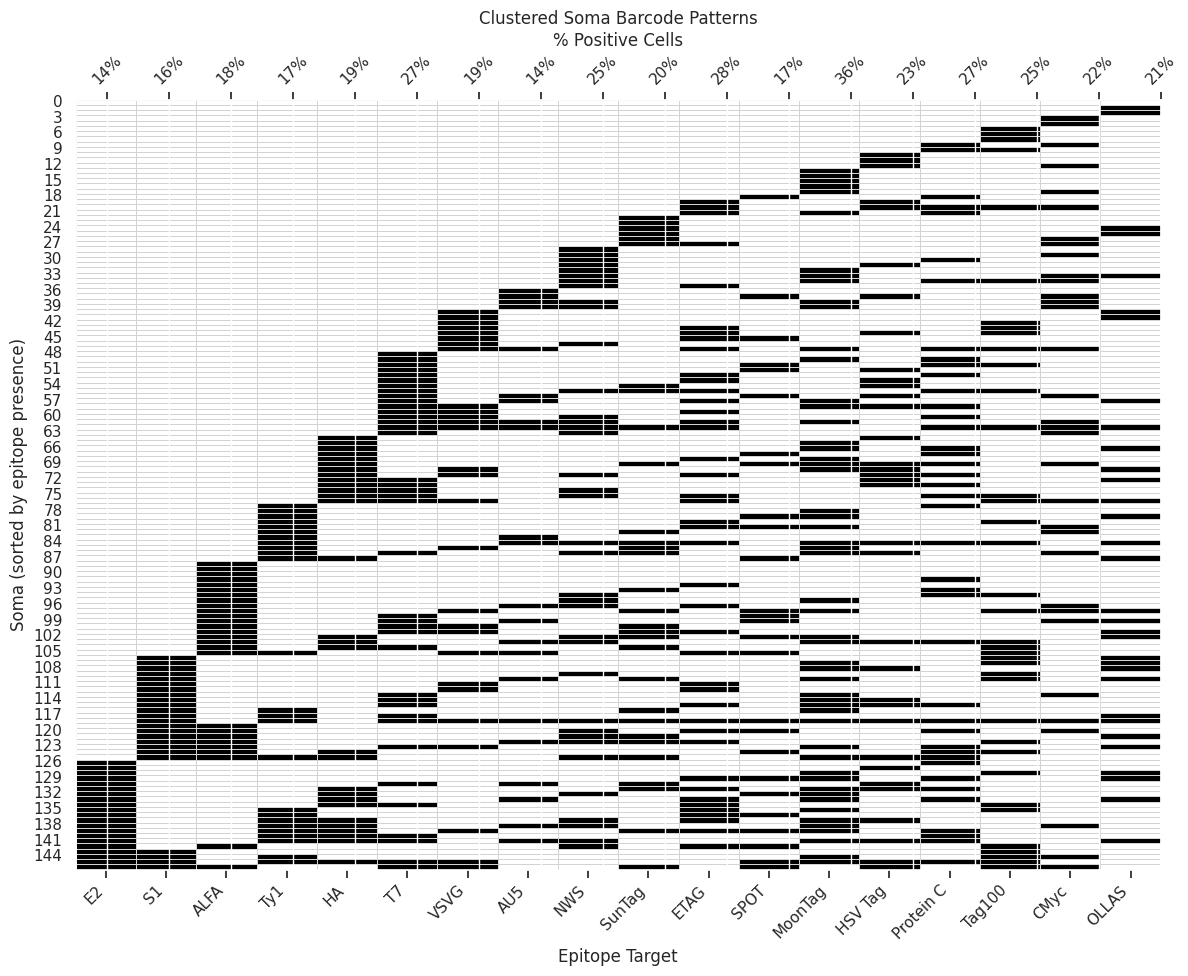

In [8]:
# trying to group them by 

# Create a sorted/clustered heatmap visualization of the soma barcodes
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd



# Extract simplified labels from the target_channels array
simplified_labels = []
for channel in target_channels:
    # Split by "-barcode" and take the first part
    epitope_name = channel.split('-barcode')[0]
    simplified_labels.append(epitope_name)

print("Simplified epitope labels:")
print(simplified_labels)



# Convert the soma_barcodes to a numpy array if it's not already
soma_barcodes_array = np.array(soma_barcodes)

# Create a DataFrame for easier manipulation
df_barcodes = pd.DataFrame(soma_barcodes_array)

# Sort the DataFrame by columns (epitopes/channels)
# This will group all cells positive for channel 0 at the top, then sort by channel 1, and so on
sorted_indices = np.lexsort([df_barcodes[col] for col in reversed(range(df_barcodes.shape[1]))])
sorted_barcodes = df_barcodes.iloc[sorted_indices].values

# Create a figure with an appropriate size
plt.figure(figsize=(14, 10))

# Create the heatmap with custom color map (white=0, black=1)
ax = sns.heatmap(sorted_barcodes, cmap=['white', 'black'], 
                cbar=False, linewidths=0.5, linecolor='lightgray')

# Turn off the grid
plt.grid(False)

# Add labels and title
plt.xlabel('Epitope Target')
plt.ylabel('Soma (sorted by epitope presence)')
plt.title('Clustered Soma Barcode Patterns')

# Set the x-axis labels to show epitope names
ax.set_xticks(np.arange(len(simplified_labels)) + 0.5)
ax.set_xticklabels(simplified_labels, rotation=45, ha='right')

# Count the number of cells that are positive for each epitope
positive_counts = df_barcodes.sum(axis=0)
total_cells = len(df_barcodes)
    
# Add a second x-axis showing the percentage of cells positive for each epitope
ax2 = ax.twiny()
ax2.set_xticks(np.arange(df_barcodes.shape[1]) + 0.5)
ax2.set_xticklabels([f"{int(count/total_cells*100)}%" for count in positive_counts], rotation=45)
ax2.set_xlabel("% Positive Cells")


plt.show()

# try sorting by epitope frequency 
# no y axis labels
# make boxes uniform 

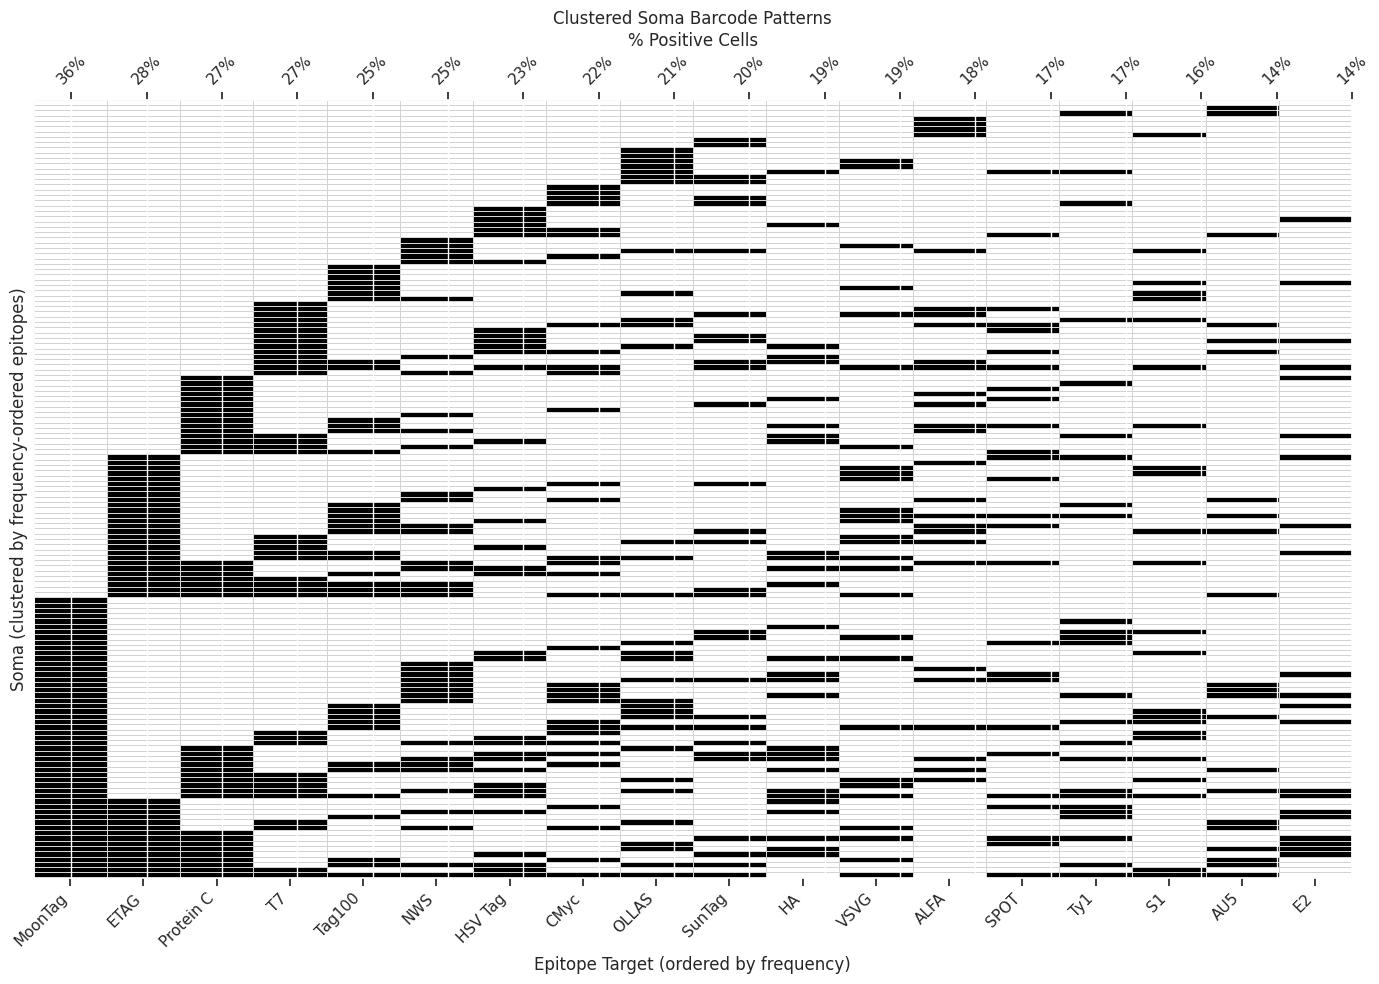

In [9]:
# frequency ordered heat map

# Convert the soma_barcodes to a numpy array if it's not already
soma_barcodes_array = np.array(soma_barcodes)

# Create a DataFrame for easier manipulation
df_barcodes = pd.DataFrame(soma_barcodes_array, columns=simplified_labels)

# Calculate the frequency of each epitope
epitope_frequencies = df_barcodes.sum(axis=0)
total_cells = len(df_barcodes)

# Get the order of columns sorted by frequency (descending)
frequency_order = epitope_frequencies.sort_values(ascending=False).index.tolist()

# Reorder the DataFrame columns by frequency
df_barcodes_reordered = df_barcodes[frequency_order]

# Now sort the rows (cells) based on the new column order
# This will cluster cells by the most frequent epitope first
sorted_indices = np.lexsort([df_barcodes_reordered[col].values for col in reversed(frequency_order)])
sorted_barcodes = df_barcodes_reordered.iloc[sorted_indices].values

# Create a figure with an appropriate size
plt.figure(figsize=(14, 10))

# Create the heatmap with custom color map (white=0, black=1)
ax = sns.heatmap(sorted_barcodes, cmap=['white', 'black'], 
                cbar=False, linewidths=0.5, linecolor='lightgray',
                yticklabels=False)  # Remove y-axis labels (soma IDs)

# Turn off the grid
plt.grid(False)

# Add labels and title
plt.xlabel('Epitope Target (ordered by frequency)')
plt.ylabel('Soma (clustered by frequency-ordered epitopes)')
plt.title('Clustered Soma Barcode Patterns')

# Set the x-axis labels to show epitope names in frequency order
ax.set_xticks(np.arange(len(frequency_order)) + 0.5)
ax.set_xticklabels(frequency_order, rotation=45, ha='right')

# Add a second x-axis showing the percentage of cells positive for each epitope
ax2 = ax.twiny()
ax2.set_xticks(np.arange(len(frequency_order)) + 0.5)
ax2.set_xticklabels([f"{int(epitope_frequencies[col]/total_cells*100)}%" for col in frequency_order], rotation=45)
ax2.set_xlabel("% Positive Cells")

plt.tight_layout()
plt.show()

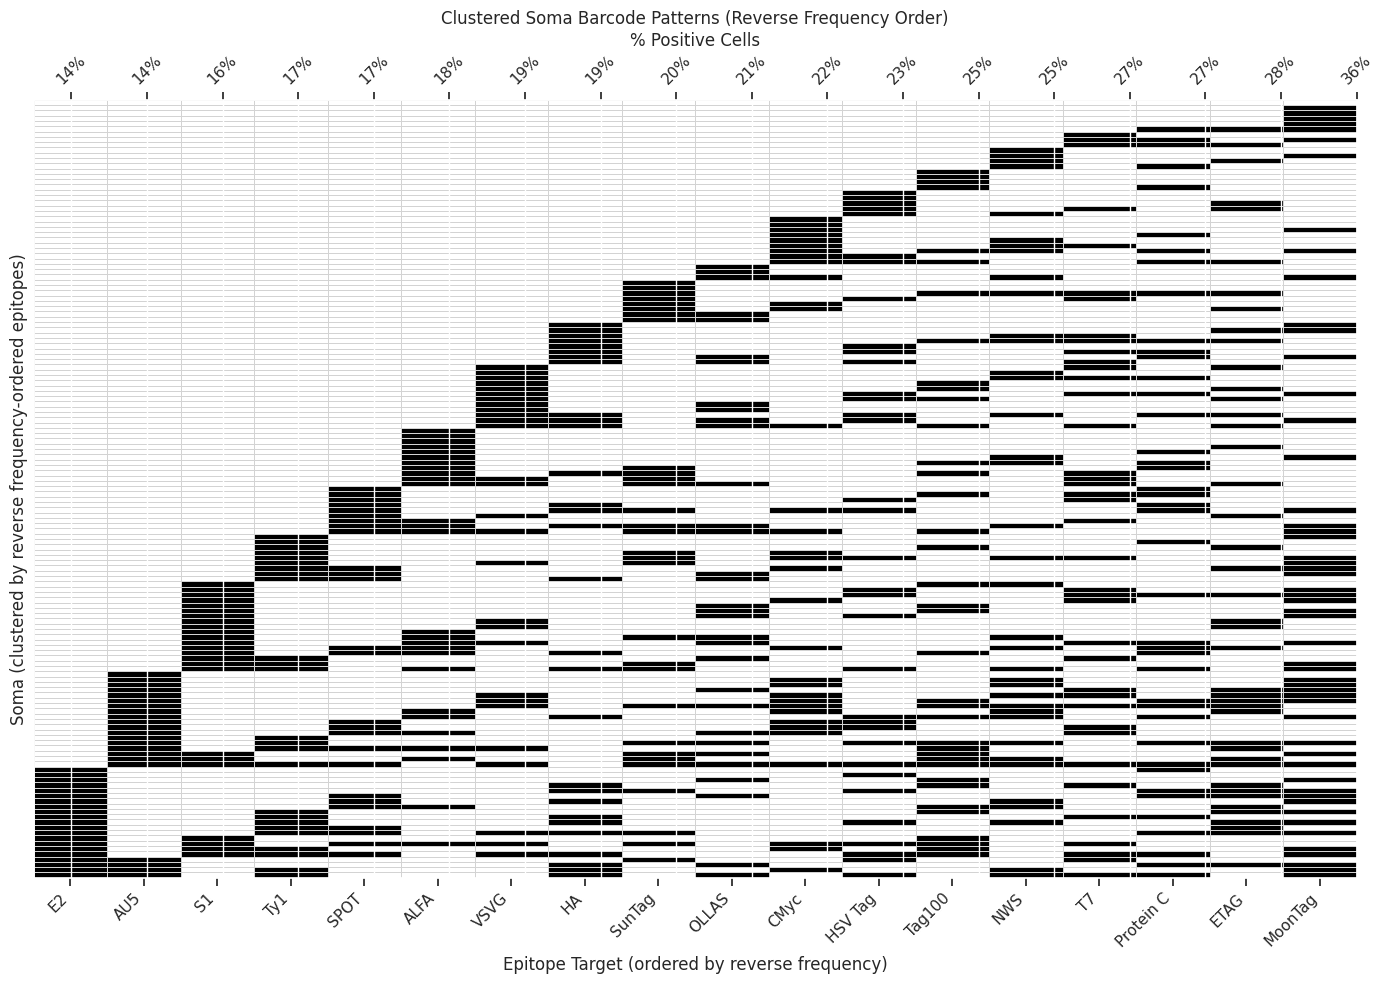

In [10]:
# reverse frequency order

# # Calculate the frequency of each epitope (same as above)
epitope_frequencies = df_barcodes.sum(axis=0)
total_cells = len(df_barcodes)

# Get the order of columns sorted by frequency (ascending - reverse order)
reverse_frequency_order = epitope_frequencies.sort_values(ascending=True).index.tolist()

# Reorder the DataFrame columns by reverse frequency
df_barcodes_reverse_ordered = df_barcodes[reverse_frequency_order]

# Sort the rows (cells) based on the new column order
sorted_indices_reverse = np.lexsort([df_barcodes_reverse_ordered[col].values for col in reversed(reverse_frequency_order)])
sorted_barcodes_reverse = df_barcodes_reverse_ordered.iloc[sorted_indices_reverse].values

# Create a figure with an appropriate size
plt.figure(figsize=(14, 10))

# Create the heatmap with custom color map (white=0, black=1)
ax = sns.heatmap(sorted_barcodes_reverse, cmap=['white', 'black'], 
                cbar=False, linewidths=0.5, linecolor='lightgray',
                yticklabels=False)  # Remove y-axis labels (soma IDs)

# Turn off the grid
plt.grid(False)

# Add labels and title
plt.xlabel('Epitope Target (ordered by reverse frequency)')
plt.ylabel('Soma (clustered by reverse frequency-ordered epitopes)')
plt.title('Clustered Soma Barcode Patterns (Reverse Frequency Order)')

# Set the x-axis labels to show epitope names in reverse frequency order
ax.set_xticks(np.arange(len(reverse_frequency_order)) + 0.5)
ax.set_xticklabels(reverse_frequency_order, rotation=45, ha='right')

# Add a second x-axis showing the percentage of cells positive for each epitope
ax2 = ax.twiny()
ax2.set_xticks(np.arange(len(reverse_frequency_order)) + 0.5)
ax2.set_xticklabels([f"{int(epitope_frequencies[col]/total_cells*100)}%" for col in reverse_frequency_order], rotation=45)
ax2.set_xlabel("% Positive Cells")

plt.tight_layout()
plt.show()


Creating heatmap for 147 somas with 18 channels


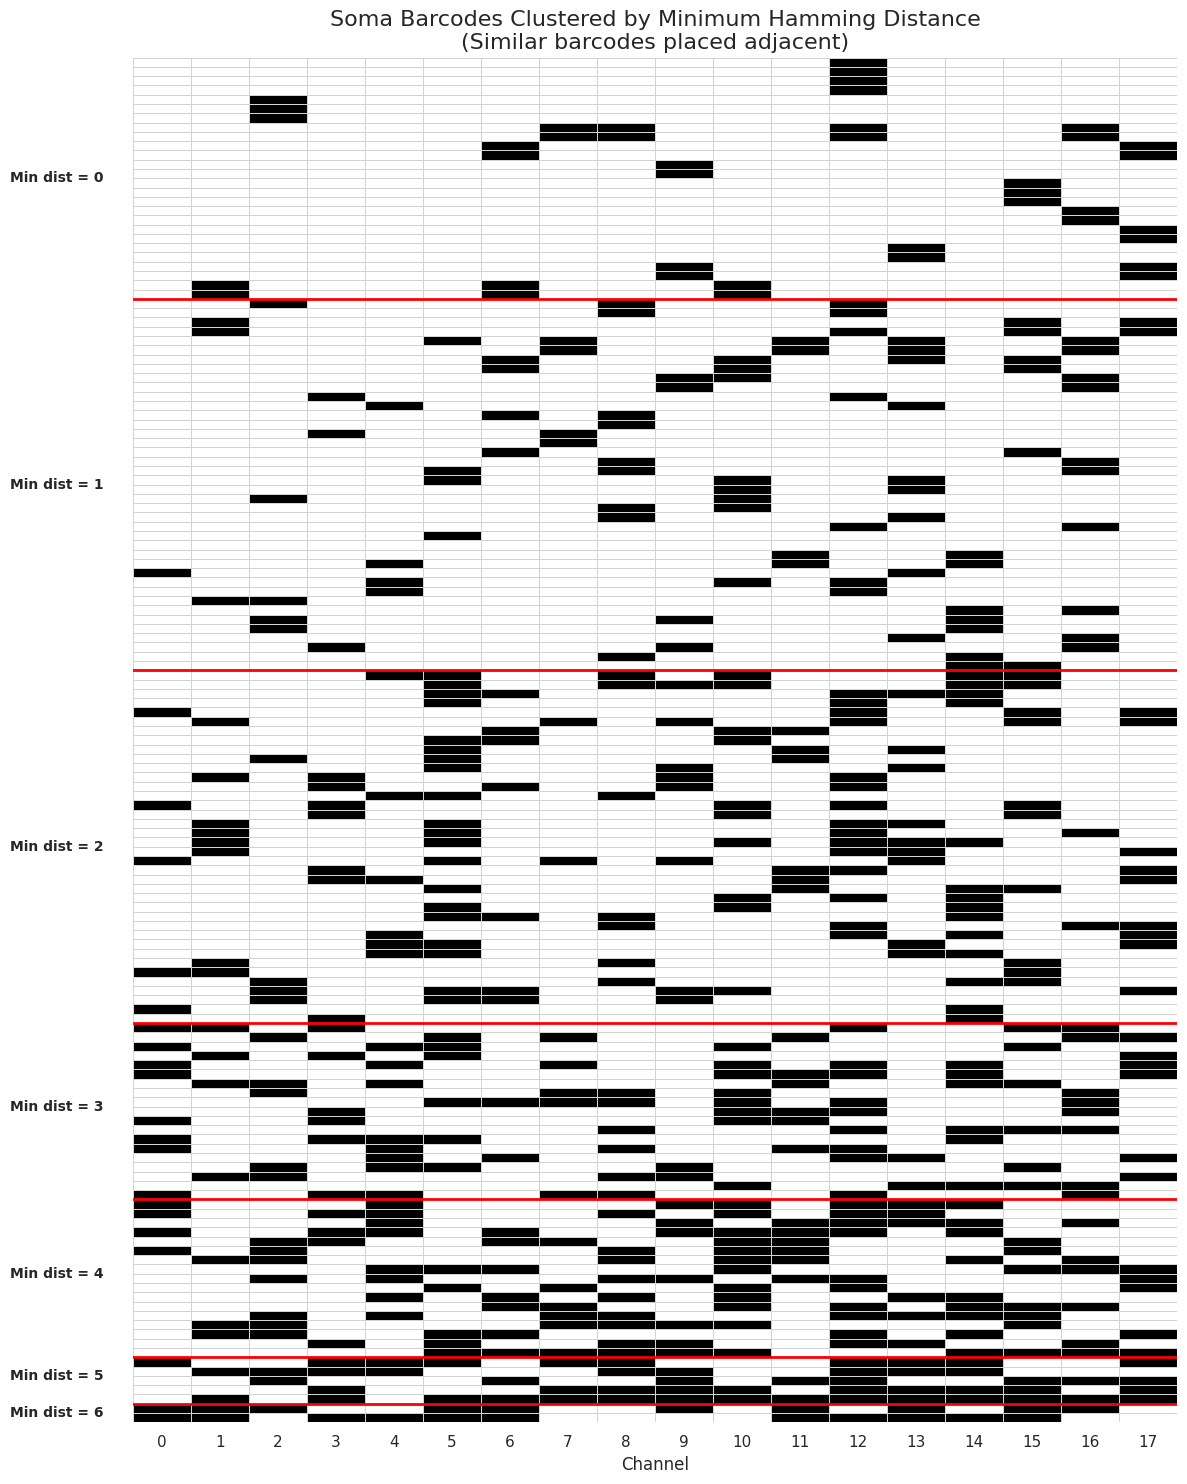

In [11]:
def create_soma_barcode_heatmap(soma_barcodes, output_path=None):
    """
    Create a heatmap of soma barcodes clustered by minimum hamming distance.
    Somas with the same minimum distance are grouped together, and within each group,
    somas are placed next to their closest pair.
    
    Parameter
    -----------
    soma_barcodes : numpy.ndarray
        A (n_somas, n_channels) array of 0s and 1s representing the presence/absence
        of protein epitopes for each soma.
    output_path : str, optional
        Path to save the figure. If None, the figure will be displayed but not saved.
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    n_somas, n_channels = soma_barcodes.shape
    print(f"Creating heatmap for {n_somas} somas with {n_channels} channels")
    
    # Calculate hamming distances between all pairs of somas
    # This computes the number of bits that differ between each pair
    bit_differences = squareform(pdist(soma_barcodes, metric='hamming') * n_channels)
    
    # Calculate the minimum hamming distance for each soma and identify its closest pair
    min_hamming_distances = []
    closest_pair_indices = []
    
    for i in range(len(bit_differences)):
        # Get all hamming distances for this soma
        distances = bit_differences[i,:]
        
        # Create a mask to exclude self-comparison (which would have distance 0)
        mask = np.ones(len(distances), dtype=bool)
        mask[i] = False
        
        # Find the minimum distance excluding self
        min_distance = np.min(distances[mask])
        min_hamming_distances.append(min_distance)
        
        # Find the index of the closest soma (there could be multiple with the same distance)
        closest_indices = np.where((distances == min_distance) & mask)[0]
        closest_pair_indices.append(closest_indices)
    
    # Convert to numpy array for easier analysis
    min_hamming_distances = np.array(min_hamming_distances)
    
    # Group somas by their minimum hamming distance
    unique_distances = np.unique(min_hamming_distances)
    
    # Create a new ordering that groups somas by min distance and keeps pairs together
    new_order = []
    processed = set()
    
    # For each unique distance value
    for dist in sorted(unique_distances):
        # Get all somas with this minimum distance
        soma_indices = np.where(min_hamming_distances == dist)[0]
        
        # Skip if all somas with this distance have been processed
        if all(idx in processed for idx in soma_indices):
            continue
        
        # Process somas with this distance that haven't been handled yet
        remaining = [idx for idx in soma_indices if idx not in processed]
        
        while remaining:
            # Start with the first unprocessed soma
            current = remaining[0]
            
            # Add it to our new ordering and mark as processed
            new_order.append(current)
            processed.add(current)
            remaining.remove(current)
            
            # Find all its closest pairs that have the same minimum distance
            pairs_to_process = [p for p in closest_pair_indices[current] 
                               if p in remaining and min_hamming_distances[p] == dist]
            
            # Add all these pairs next in the ordering
            for pair in pairs_to_process:
                if pair in remaining:
                    new_order.append(pair)
                    processed.add(pair)
                    remaining.remove(pair)
    
    # Reorder soma_barcodes based on the new ordering
    sorted_barcodes = soma_barcodes[new_order]
    sorted_min_distances = min_hamming_distances[new_order]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 15))
    
    # Plot the barcode heatmap with a grid
    ax = sns.heatmap(sorted_barcodes, cmap=['white', 'black'],
                     linewidths=0.5, linecolor='lightgray',
                     yticklabels=False, cbar=False)
    
    # Set x-axis labels for the channels
    ax.set_xticks(np.arange(n_channels) + 0.5)
    ax.set_xticklabels(range(n_channels))
    ax.set_xlabel('Channel')
    
    # Add horizontal lines to separate somas with different minimum distances
    boundaries = []
    current_dist = sorted_min_distances[0]
    
    for i in range(1, len(sorted_min_distances)):
        if sorted_min_distances[i] != current_dist:
            boundaries.append(i)
            current_dist = sorted_min_distances[i]
    
    # Add thicker red lines at the boundaries between different min distances
    for boundary in boundaries:
        ax.axhline(y=boundary, color='red', linestyle='-', linewidth=2)
    
    # Add annotations for each group
    prev_boundary = 0
    for boundary in boundaries + [len(sorted_min_distances)]:
        mid = (prev_boundary + boundary) // 2
        dist_value = sorted_min_distances[prev_boundary]
        
        # Add text annotation for the minimum distance
        ax.text(-0.5, mid, f"Min dist = {int(dist_value)}", 
                verticalalignment='center', horizontalalignment='right',
                fontsize=10, fontweight='bold')
        
        prev_boundary = boundary
    
    plt.title('Soma Barcodes Clustered by Minimum Hamming Distance\n(Similar barcodes placed adjacent)', fontsize=16)
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

    
# Create and show the heatmap
create_soma_barcode_heatmap(soma_barcodes)
plt.show()


Creating hierarchical clustered heatmap for 147 somas with 18 channels
Using ward linkage method


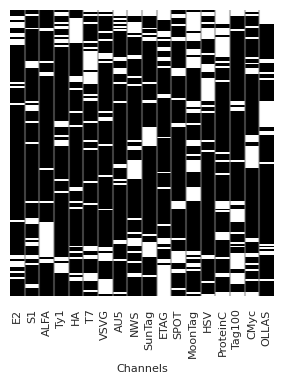

In [ ]:
# hiearchichal clustering approach

"""
Simple script to create a hierarchical clustered heatmap of soma barcodes.\
"""

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list

# Function to create the hierarchical clustered heatmap
def create_hierarchical_clustered_heatmap(soma_barcodes, method=None, output_path=None):
    """Create a heatmap of soma barcodes with hierarchical clustering using Hamming distance."""
    n_somas, n_channels = soma_barcodes.shape
    print(f"Creating hierarchical clustered heatmap for {n_somas} somas with {n_channels} channels")
    print(f"Using {method} linkage method")
    
    # Calculate Hamming distances between all pairs of somas
    hamming_distances = pdist(soma_barcodes, metric='hamming')
    
    # Create the linkage matrix
    Z = linkage(hamming_distances, method=method)
    
    # Get the order of samples from the hierarchical clustering
    cluster_order = leaves_list(Z)
    
    # Reorder the soma barcodes according to the clustering
    clustered_barcodes = soma_barcodes[cluster_order]
    
    # Create figure for the heatmap only
    fig, ax_heatmap = plt.subplots(figsize=(3, 4))
 
    # Plot the heatmap with inverted colors (binary_r) and no grid lines
    ax = sns.heatmap(clustered_barcodes, ax=ax_heatmap, cmap='binary_r',
                yticklabels=False, cbar=False, vmin=0, vmax=1,
                linewidths=0, linecolor='white')  # Removed grid by setting linewidths=0
    
    # Set x-axis labels for the target channels with simplified names
    channel_names = ['E2', 'S1', 'ALFA', 'Ty1', 'HA', 'T7', 
                     'VSVG', 'AU5', 'NWS', 'SunTag', 'ETAG', 
                     'SPOT', 'MoonTag', 'HSV', 'ProteinC', 
                     'Tag100', 'CMyc', 'OLLAS']
    ax_heatmap.set_xticks(np.arange(n_channels) + 0.5)
    ax_heatmap.set_xticklabels(channel_names, rotation=90, fontsize=8)
    ax_heatmap.set_xlabel('Channels', fontsize=8)

    ax_heatmap.set_ylabel('Somas')
    
    # Add vertical grey lines between columns
    for i in range(1, n_channels):
        ax_heatmap.axvline(x=i, color='grey', linestyle='-', linewidth=1.5, alpha=0.5)

    ax.grid(False)

    
    # plt.title('Soma Barcodes with Hierarchical Clustering', fontsize=16)
    plt.tight_layout()

    
    return fig, ax_heatmap


# Create the hierarchical clustered heatmap with average linkage (recommended default)
fig, ax_heatmap = create_hierarchical_clustered_heatmap(
    soma_barcodes, 
    method='ward',
    output_path="soma_hierarchical_clustering.png"
)


# Display the figure
plt.show()




# Uncomment these lines to try different linkage methods
# Methods: 'single', 'complete', 'average', 'ward'

# methods = ['single', 'complete', 'average', 'ward']
# for method in methods:
#     print(f"\nTrying {method} linkage method...")
#     fig, _ = create_hierarchical_clustered_heatmap(
#         soma_barcodes, 
#         method=method,
#         output_path=f"soma_hierarchical_clustering_{method}.png"
#     )
#     plt.close(fig)  # Close the figure to avoid showing all at once


# remove grid lines
# try to show dendogram with clustering 


# text size 8



## Plotting Length distritbution

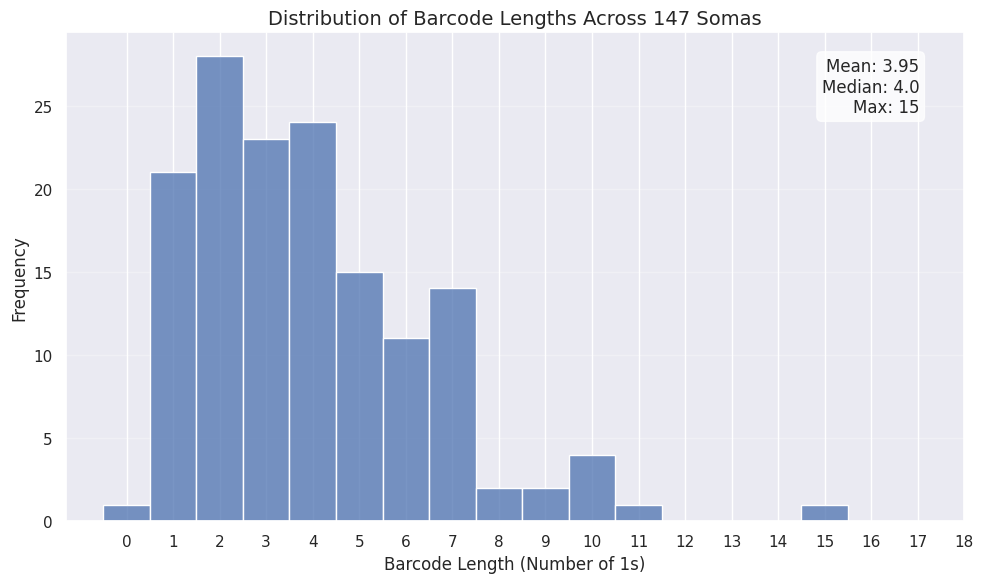

Total cells: 147
Mean barcode length: 3.95
Median barcode length: 4.0
Min barcode length: 0
Max barcode length: 15


In [13]:
# Calculate barcode length (sum of 1s) for each cell
barcode_lengths = np.sum(soma_barcodes, axis=1)

# Create a figure with appropriate size
plt.figure(figsize=(10, 6))

# Create the histogram
sns.histplot(barcode_lengths, kde=False, bins=range(19), discrete=True)

# Add labels and title
plt.xlabel('Barcode Length (Number of 1s)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Distribution of Barcode Lengths Across {len(barcode_lengths)} Somas', fontsize=14)

# Set x-axis ticks to include all possible barcode lengths (0 to 18)
plt.xticks(range(19))

# Add a grid for better readability
plt.grid(axis='y', alpha=0.3)

# Calculate some statistics to add as text
mean_length = np.mean(barcode_lengths)
median_length = np.median(barcode_lengths)
max_length = np.max(barcode_lengths)

# Add statistics as text
stats_text = f"Mean: {mean_length:.2f}\nMedian: {median_length:.1f}\nMax: {max_length:.0f}"
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Show the plot
plt.tight_layout()
plt.show()

# Also print basic statistics
print(f"Total cells: {len(barcode_lengths)}")
print(f"Mean barcode length: {mean_length:.2f}")
print(f"Median barcode length: {median_length}")
print(f"Min barcode length: {np.min(barcode_lengths)}")
print(f"Max barcode length: {max_length}")

## Distibution Analysis


Average epitope presence: 21.96% of cells
Median epitope presence: 21.09% of cells


<Figure size 4200x2400 with 0 Axes>

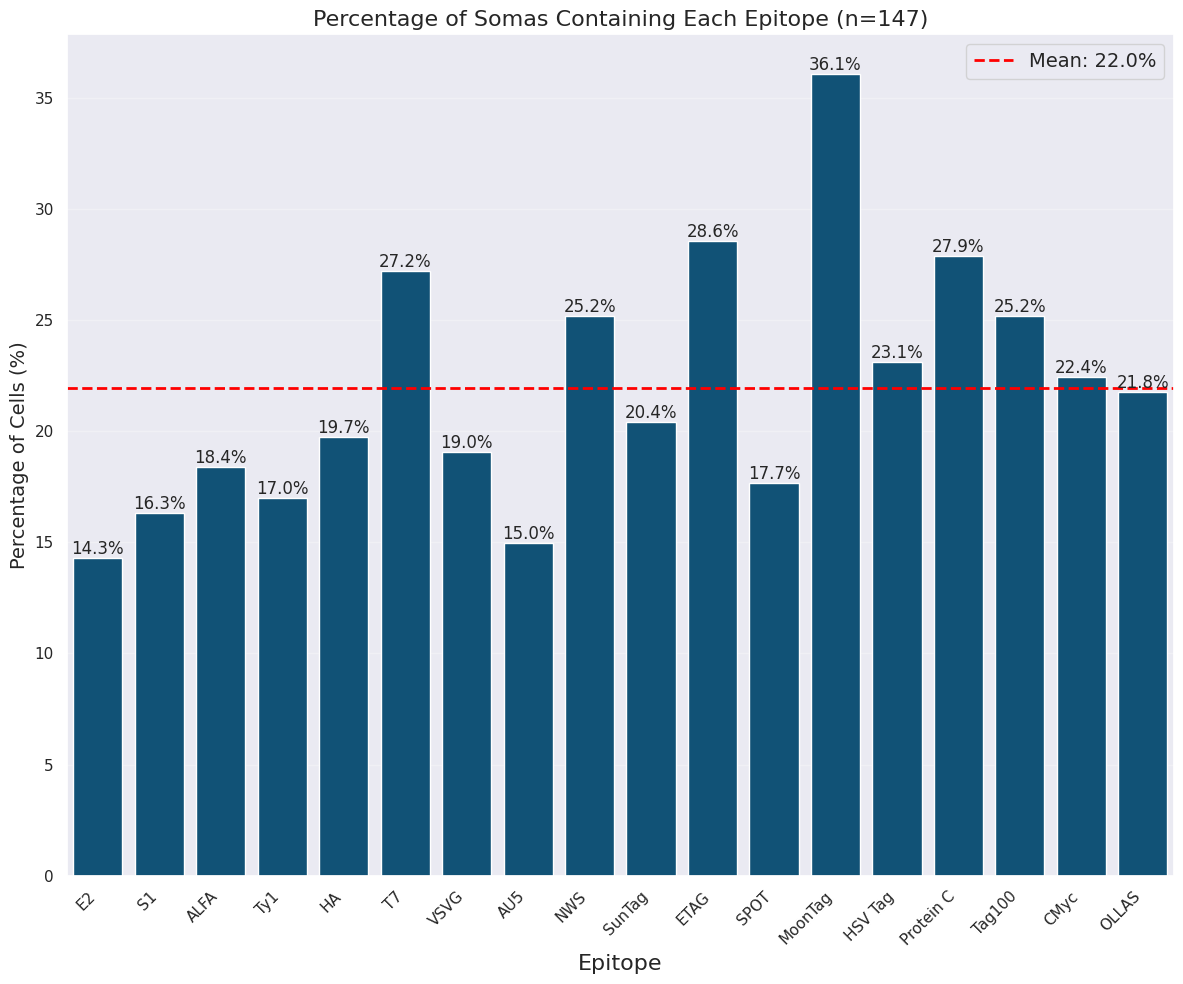

In [14]:
plt.figure(figsize=(14, 8), dpi=300)

epitope_counts = np.sum(soma_barcodes, axis=0)  # Sum each column
total_cells = len(soma_barcodes)
epitope_percentages = (epitope_counts / total_cells) * 100

# Calculate the average percentage
mean_percentage = np.mean(epitope_percentages)
median_percentage = np.median(epitope_percentages)

# Create a DataFrame for easier plotting with the target names
# Extract just the first part of each epitope name (before "-barcode")
simplified_epitopes = [name.split('-')[0] for name in target_channels]
epitope_df = pd.DataFrame({
    'Epitope': simplified_epitopes,
    'Percentage': epitope_percentages
})

# Sort from highest to lowest percentage for better visualization
# epitope_df = epitope_df.sort_values('Percentage', ascending=False)

# Create the plot
plt.figure(figsize=(12, 10))
bars = sns.barplot(x='Epitope', y='Percentage', data=epitope_df, color=e11_color)

# Add percentage labels on top of each bar
for i, p in enumerate(bars.patches):
    bars.annotate(f'{p.get_height():.1f}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=12)

# Add a horizontal line for the average
mean_line = plt.axhline(y=mean_percentage, color='red', linestyle='--', linewidth=2, 
                        label=f'Mean: {mean_percentage:.1f}%')

# Add labels and title
plt.xlabel('Epitope', fontsize=16)
plt.ylabel('Percentage of Cells (%)', fontsize=14)
plt.title(f'Percentage of Somas Containing Each Epitope (n={len(soma_barcodes)})', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid lines for easier reading
plt.grid(axis='y', alpha=0.3)

# Add legend
plt.legend(fontsize=14)

# Adjust layout and show plot
plt.tight_layout()


# Print the average clearly
print(f"\nAverage epitope presence: {mean_percentage:.2f}% of cells")
print(f"Median epitope presence: {median_percentage:.2f}% of cells")



## Hand Called vs Predicted Distribution

This is literally just hard coded reading off the values of both histograms. A cleaner approach is to integrate both notebooks and do this programatically. 

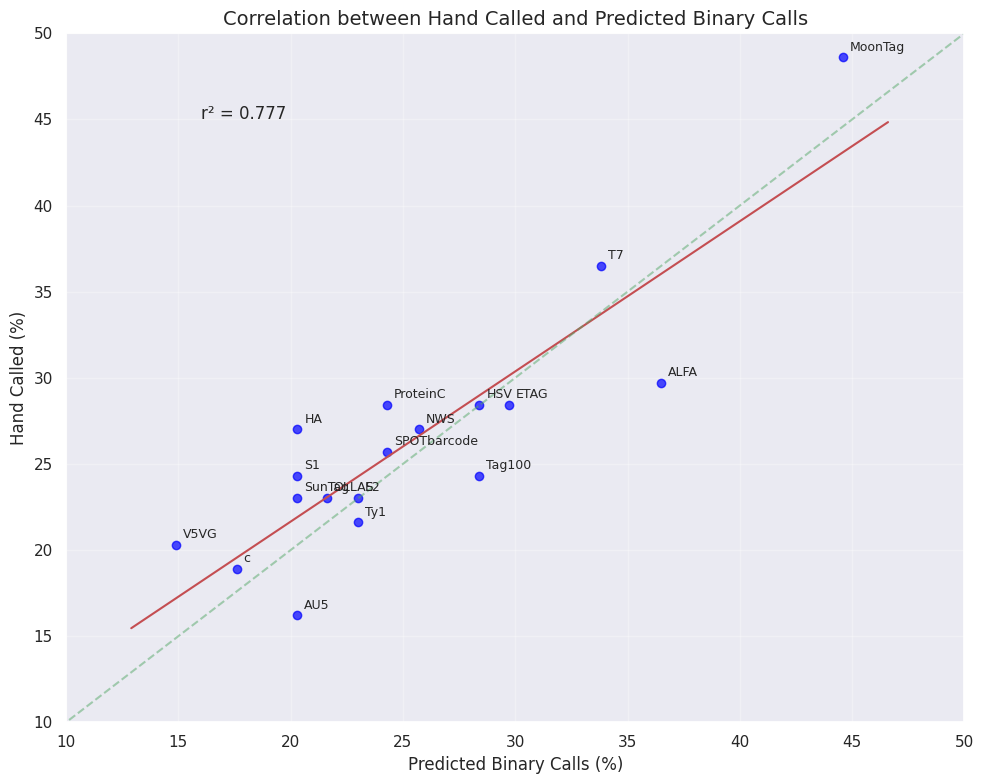

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Correct epitope names from the x-axis
epitopes = [
    "E2-barcode-R1", "S1-barcode-R1", "ALFA-barcode-R1", "Ty1-barcode-R2", 
    "HA-barcode-R2", "T7-barcode-R3", "V5VG-barcode-R3", "AU5-barcode-R8", 
    "NWS-barcode-R9", "SunTag-barcode-R9", "ETAG-barcode-R9", "SPOTbarcode-R10", 
    "MoonTag-barcode-R10", "HSV-barcode-R10", "ProteinC-barcode-R11", 
    "Tag100-barcode-R11", "c-MYC-barcode-R11", "OLLAS-barcode-R12"
]

# Data from Image 1 (Hand called)
hand_called = [
    23.0, 24.3, 29.7, 21.6, 27.0, 36.5, 20.3, 16.2, 27.0, 23.0, 28.4,25.7, 48.6, 
    28.4, 28.4, 24.3, 18.9, 23.0
]

# Data from Image 2 (Predicted binary calls)
predicted = [
    23.0, 20.3, 36.5, 23.0, 20.3, 33.8, 14.9, 20.3, 25.7, 20.3, 29.7, 24.3,44.6, 
    28.4,24.3, 28.4, 17.6, 21.6
]

# Calculate correlation and linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(predicted, hand_called)
r_squared = r_value**2

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(predicted, hand_called, c='blue', alpha=0.7)

# Add labels for each point with shortened names
for i, epitope in enumerate(epitopes):
    # Extract just the main part of the epitope name before the hyphen
    short_name = epitope.split('-')[0]
    plt.annotate(short_name, (predicted[i], hand_called[i]), 
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=9)

# Add regression line
x_range = np.linspace(min(predicted)-2, max(predicted)+2, 100)
plt.plot(x_range, slope * x_range + intercept, 'r-')

# Add text with correlation information
plt.text(16, 45, f'r² = {r_squared:.3f}', fontsize=12)

# Set labels and title
plt.xlabel('Predicted Binary Calls (%)', fontsize=12)
plt.ylabel('Hand Called (%)', fontsize=12)
plt.title('Correlation between Hand Called and Predicted Binary Calls', fontsize=14)

# Set equal aspect ratio and axis limits
plt.axis([10, 50, 10, 50])

# Add identity line (y=x)
plt.plot([0, 50], [0, 50], 'g--', alpha=0.5)

# Add grid
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Collisions

### SOmas exlcuidng the single epitope expressing somas

Total cells/somas: 147
Unique barcodes: 132
Barcode collision distribution: {0: 121, 1: 16, 2: 6, 3: 4}
Percentage of cells with unique barcodes: 82.31%


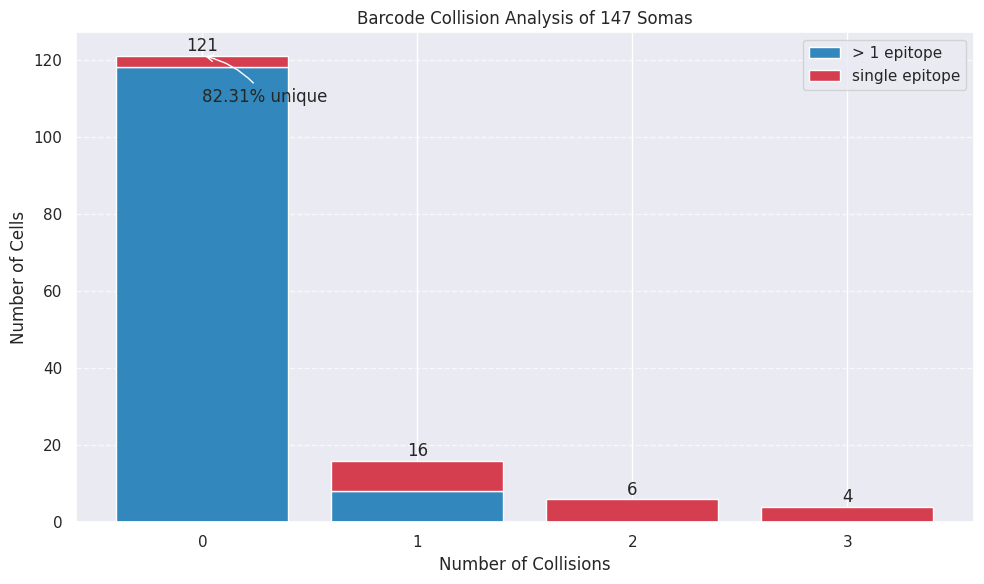

In [16]:
# Collision Analysis and Visualization
def analyze_barcode_collisions(segments_array):
    """
    Analyze barcode collisions in the segments array.
    
    Parameters:
    - segments_array: numpy array where each row represents a cell/soma and each column is a barcode bit
    
    Returns:
    - Dictionary containing collision analysis results
    """
    # Create a tuple for each barcode to make it hashable for counting
    barcodes = [tuple(row) for row in segments_array]
    
    # Count occurrences of each barcode
    from collections import Counter
    barcode_counts = Counter(barcodes)
    
    # Calculate collision statistics
    collision_counts = Counter(barcode_counts.values())
    
    # For each count value, the number of cells having that many collisions
    # is count_value * number_of_barcodes_with_that_count
    collision_distribution = {}
    total_cells = len(segments_array)
    total_accounted = 0
    
    for count_value, num_barcodes in sorted(collision_counts.items()):
        num_cells = count_value * num_barcodes
        collision_distribution[count_value-1] = num_cells  # count_value-1 is the number of collisions
        total_accounted += num_cells
    
    # Verify all cells are accounted for
    assert total_accounted == total_cells, f"Error: {total_accounted} cells accounted for, but expected {total_cells}"
    
    return {
        'collision_distribution': collision_distribution,
        'total_cells': total_cells,
        'unique_barcodes': len(barcode_counts),
        'barcode_counts': barcode_counts
    }

# Assuming 'segments' is your array containing all barcodes for the 147 somas
# If you need to create it from the processed dataframe, use:
# segments = processed_df[target_channels].values

# Analyze collisions
collision_results = analyze_barcode_collisions(soma_barcodes)

# Display basic statistics
print(f"Total cells/somas: {collision_results['total_cells']}")
print(f"Unique barcodes: {collision_results['unique_barcodes']}")
print(f"Barcode collision distribution: {collision_results['collision_distribution']}")

# Calculate what percentage of cells have a unique barcode
unique_cells = collision_results['collision_distribution'].get(0, 0)
percent_unique = (unique_cells / collision_results['total_cells']) * 100
print(f"Percentage of cells with unique barcodes: {percent_unique:.2f}%")

# Count the number of positive epitopes for each soma
epitope_counts = np.sum(soma_barcodes, axis=1)

# Create a visualization of the collision distribution
plt.figure(figsize=(10, 6))
collision_data = collision_results['collision_distribution']
collisions = sorted(collision_data.keys())
cell_counts = [collision_data[c] for c in collisions]

# Create a color map - one color for single epitope somas, another for multi-epitope somas
# Using colorblind-friendly colors
# Blue and orange from the viridis/plasma palette
multi_epitope_color = '#3288bd'  # Blue
single_epitope_color = '#d53e4f'  # Red

colors = []
for c in collisions:
    # For each collision count, determine how many cells have single vs multiple epitopes
    # Get the barcodes with this collision count
    collision_barcodes = [b for b, count in collision_results['barcode_counts'].items() 
                         if count-1 == c]
    
    # Find all cells with these barcodes
    cells_with_this_collision = []
    for i, barcode in enumerate(soma_barcodes):
        if tuple(barcode) in collision_barcodes:
            cells_with_this_collision.append(i)
    
    # Count single epitope cells in this collision group
    single_epitope_count = sum(1 for i in cells_with_this_collision if epitope_counts[i] == 1)
    multi_epitope_count = len(cells_with_this_collision) - single_epitope_count
    
    # Store counts for stacked bar chart
    colors.append((single_epitope_count, multi_epitope_count))

# Bar plot with stacked colors
bottoms = [0] * len(collisions)
bars_multi = plt.bar(collisions, [m for _, m in colors], color=multi_epitope_color, label='> 1 epitope')
bars_single = plt.bar(collisions, [s for s, _ in colors], bottom=[m for _, m in colors], 
                      color=single_epitope_color, label='single epitope')

# Add value labels on top of bars
for i, c in enumerate(collisions):
    total_height = colors[i][0] + colors[i][1]
    plt.text(c, total_height + 0.1, f'{total_height}', ha='center', va='bottom')

plt.title(f'Barcode Collision Analysis of {collision_results["total_cells"]} Somas')
plt.xlabel('Number of Collisions')
plt.ylabel('Number of Cells')
plt.xticks(collisions)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Add percentage annotation for unique barcodes
plt.annotate(f"{percent_unique:.2f}% unique", 
             xy=(0, cell_counts[collisions.index(0)] if 0 in collisions else 0), 
             xytext=(0, max(cell_counts)*0.9),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.tight_layout()
plt.show()


--- After filtering somas with only one epitope ---
Total cells/somas: 125
Unique barcodes: 121
Barcode collision distribution: {0: 117, 1: 8}
Percentage of cells with unique barcodes: 93.60%


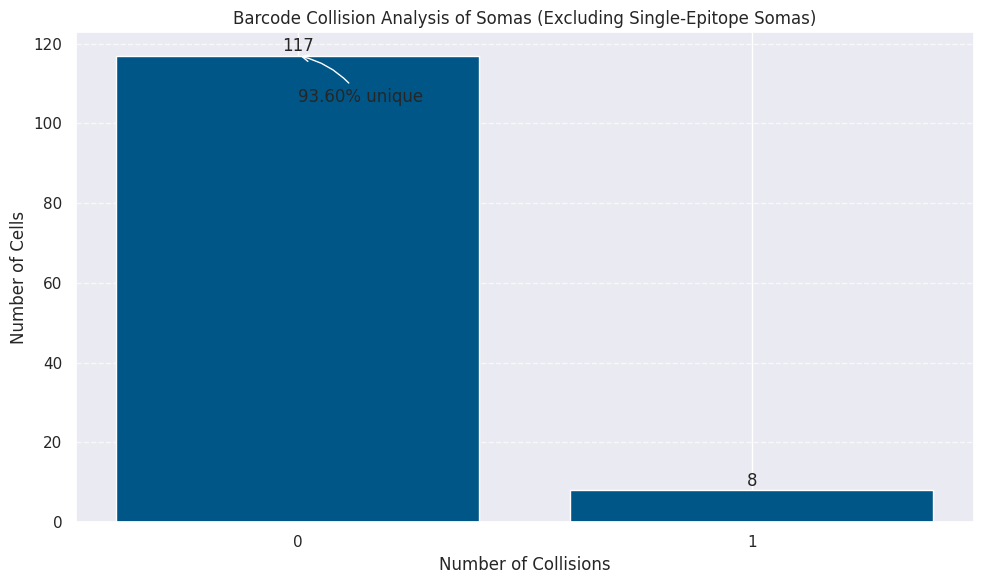

In [17]:
# Now analyze collisions after filtering out somas with only a single epitope barcode


# Count the number of positive epitopes for each soma
epitope_counts = np.sum(soma_barcodes, axis=1)

# Filter out somas with only one epitope
filtered_indices = np.where(epitope_counts > 1)[0]
filtered_barcodes = soma_barcodes[filtered_indices]

# Analyze collisions for the filtered dataset
filtered_collision_results = analyze_barcode_collisions(filtered_barcodes)

# Display basic statistics for filtered dataset
print("\n--- After filtering somas with only one epitope ---")
print(f"Total cells/somas: {filtered_collision_results['total_cells']}")
print(f"Unique barcodes: {filtered_collision_results['unique_barcodes']}")
print(f"Barcode collision distribution: {filtered_collision_results['collision_distribution']}")

# Calculate what percentage of filtered cells have a unique barcode
filtered_unique_cells = filtered_collision_results['collision_distribution'].get(0, 0)
filtered_percent_unique = (filtered_unique_cells / filtered_collision_results['total_cells']) * 100 if filtered_collision_results['total_cells'] > 0 else 0
print(f"Percentage of cells with unique barcodes: {filtered_percent_unique:.2f}%")

# Create a visualization of the filtered collision distribution
plt.figure(figsize=(10, 6))
filtered_collision_data = filtered_collision_results['collision_distribution']
filtered_collisions = sorted(filtered_collision_data.keys())
filtered_cell_counts = [filtered_collision_data[c] for c in filtered_collisions]

# Bar plot
filtered_bars = plt.bar(filtered_collisions, filtered_cell_counts, color=e11_color)

# Add value labels on top of bars
for bar in filtered_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height}', ha='center', va='bottom')

plt.title('Barcode Collision Analysis of Somas (Excluding Single-Epitope Somas)')
plt.xlabel('Number of Collisions')
plt.ylabel('Number of Cells')
plt.xticks(filtered_collisions)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage annotation for unique barcodes
if filtered_percent_unique > 0:
    plt.annotate(f"{filtered_percent_unique:.2f}% unique", 
                xy=(0, filtered_cell_counts[filtered_collisions.index(0)] if 0 in filtered_collisions else 0), 
                xytext=(0, max(filtered_cell_counts)*0.9 if filtered_cell_counts else 0),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.tight_layout()
plt.show()



## Hamming Distance analysis

Note: there are only skeletons for 

In [18]:
# compute distance matrix
dist = distance.pdist(soma_barcodes, metric="hamming")
matrix = distance.squareform(dist)

# Set values close to zero, directly to zero (for cosine precision)
matrix[matrix < 1e-10] = 0

matrix

array([[0.        , 0.55555556, 0.55555556, ..., 0.55555556, 0.61111111,
        0.44444444],
       [0.55555556, 0.        , 0.55555556, ..., 0.66666667, 0.38888889,
        0.44444444],
       [0.55555556, 0.55555556, 0.        , ..., 0.44444444, 0.27777778,
        0.33333333],
       ...,
       [0.55555556, 0.66666667, 0.44444444, ..., 0.        , 0.61111111,
        0.66666667],
       [0.61111111, 0.38888889, 0.27777778, ..., 0.61111111, 0.        ,
        0.27777778],
       [0.44444444, 0.44444444, 0.33333333, ..., 0.66666667, 0.27777778,
        0.        ]], shape=(147, 147))

In [19]:
bit_differences = matrix * soma_barcodes.shape[1]

max_bit_difference = int(np.max(bit_differences))
bins = np.arange(0, max_bit_difference + 1)

rows, columns = bit_differences.shape
flat = bit_differences.reshape(rows * columns)

print(flat)

[ 0. 10. 10. ... 12.  5.  0.]


[ 0  0  0 ... 16 16 16]


NameError: name 'num_columns' is not defined

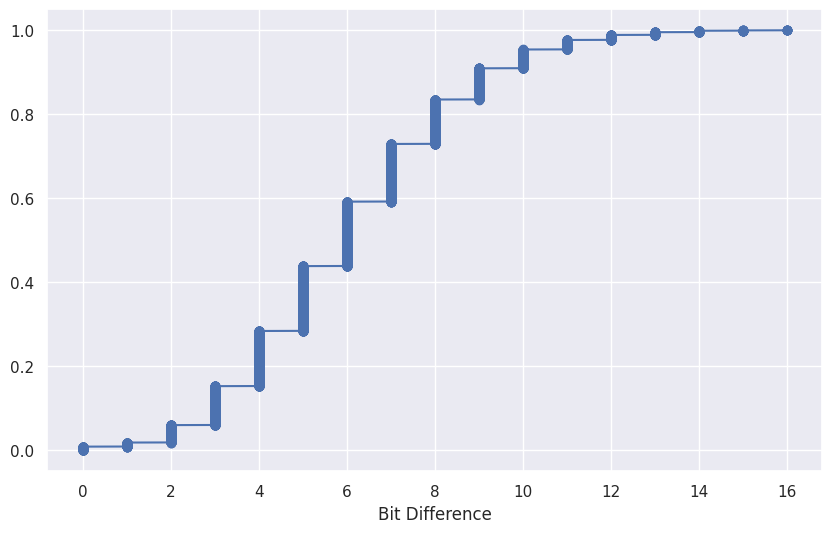

In [20]:
# Plotting the cumulative histogram
plt.figure(figsize=(10, 6))

# sort the data in ascending order
x = np.sort(flat).astype(int)

print(x)

num_cells = x.shape[0]

# get the cdf values of y
y = np.arange(num_cells) / float(num_cells)

plt.plot(x, y, marker="o")
plt.xlabel("Bit Difference")
plt.xticks(list(range(num_columns+1)))
plt.ylabel("Cumulative Probability")
plt.title(
    "Cumulative hist of pairwise hamming distances of"
    f" {total_cells} cells"
)
plt.grid(True)

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5])

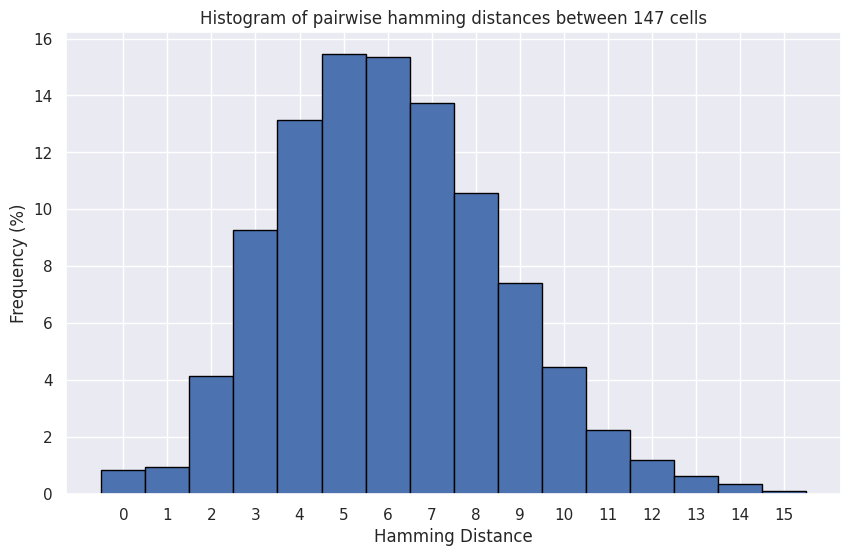

In [35]:
# Plot histogram of hamming distances
plt.figure(figsize=(10, 6))
plt.hist(flat, bins=bins, edgecolor='black', weights=np.ones_like(flat)/len(flat)*100, align='mid')
plt.xlabel("Hamming Distance")
plt.ylabel("Frequency (%)")
plt.title(f"Histogram of pairwise hamming distances between {total_cells} cells")
plt.xticks(bins[:-1] + 0.5, bins[:-1])


np.arange(-0.5, soma_barcodes.shape[1] + 1.5)

Original data: (147, 18), Filtered data: (147, 18)


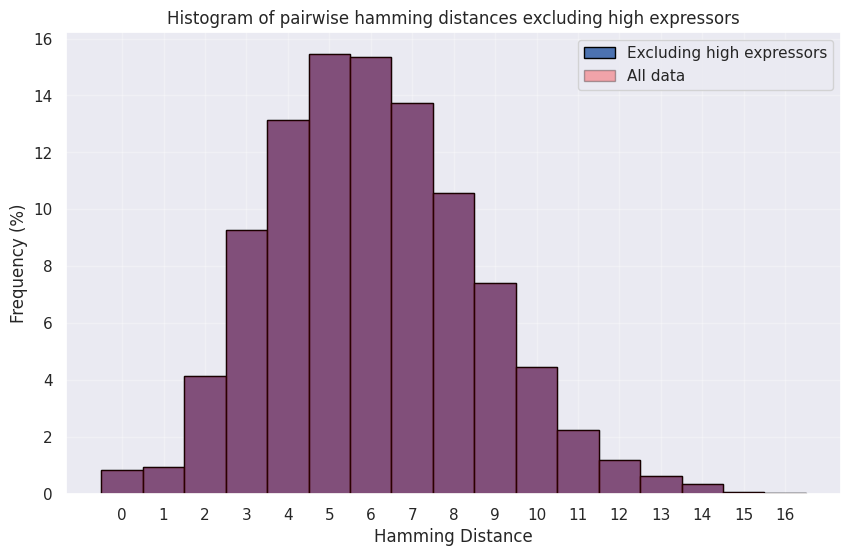

Mean hamming distance for all data: 6.06
Mean hamming distance excluding high expressors: 6.06


In [41]:
expressions_per_object = np.nansum(soma_barcodes, axis=1)



# Create a mask to exclude high expressors (neurons expressing > 17 channels)
mask = expressions_per_object <= 17  # Excludes the high expressors

# Get the filtered thresholded data
filtered_thresholded = soma_barcodes[mask]
print(f"Original data: {soma_barcodes.shape}, Filtered data: {filtered_thresholded.shape}")

# Compute new distance matrix on filtered data
filtered_dist = distance.pdist(filtered_thresholded, metric="hamming")
filtered_matrix = distance.squareform(filtered_dist)

# Set values close to zero, directly to zero (for precision)
filtered_matrix[filtered_matrix < 1e-10] = 0

# Convert to bit differences
filtered_bit_differences = filtered_matrix * filtered_thresholded.shape[1]

# Flatten the matrix
rows, columns = filtered_bit_differences.shape
filtered_flat = filtered_bit_differences.reshape(rows * columns)

# Plot histogram of hamming distances for filtered data
plt.figure(figsize=(10, 6))

# Get bin parameters
max_bit_difference = int(np.max(filtered_bit_differences))
bins = np.arange(0, max_bit_difference + 2)

# Create histogram with percentage frequency
plt.hist(filtered_flat, bins=bins, edgecolor='black', 
         weights=np.ones_like(filtered_flat)/len(filtered_flat)*100, align='mid')

plt.xlabel("Hamming Distance")
plt.ylabel("Frequency (%)")
plt.title(f"Histogram of pairwise hamming distances excluding high expressors")
plt.xticks(bins[:-1] + 0.5, bins[:-1])

# For comparison, add the original histogram in a different color with transparency
plt.hist(flat, bins=np.arange(0, int(np.max(bit_differences)) + 2), 
         edgecolor='black', alpha=0.3, color='red',
         weights=np.ones_like(flat)/len(flat)*100, align='mid')

plt.legend(['Excluding high expressors', 'All data'])
plt.grid(alpha=0.3)
plt.show()

# Calculate mean hamming distances
mean_all = np.mean(flat)
mean_filtered = np.mean(filtered_flat)

print(f"Mean hamming distance for all data: {mean_all:.2f}")
print(f"Mean hamming distance excluding high expressors: {mean_filtered:.2f}")


(147,)


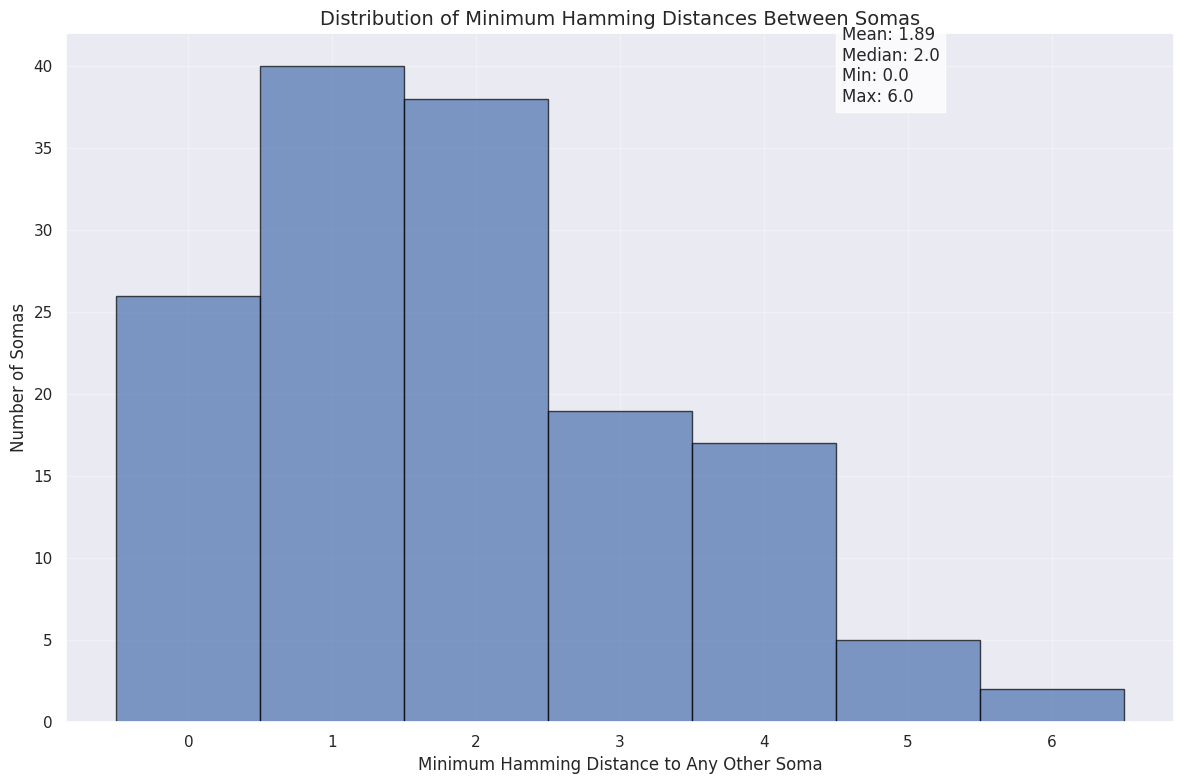

Minimum Hamming Distance Statistics:
Mean: 1.89
Median: 2.0
Min: 0.0
Max: 6.0
Total number of somas analyzed: 147


In [65]:
# Calculate the minimum hamming distance for each soma (excluding self-comparison)
min_hamming_distances = []

for i in range(len(bit_differences)):
    # Get all hamming distances for this soma
    distances = bit_differences[i,:]
    
    # Create a mask to exclude self-comparison (which would have distance 0)
    mask = np.ones(len(distances), dtype=bool)
    mask[i] = False
    
    # Find the minimum distance excluding self
    min_distance = np.min(distances[mask])
    min_hamming_distances.append(min_distance)

# Convert to numpy array for easier analysis
min_hamming_distances = np.array(min_hamming_distances)
print(min_hamming_distances.shape)

# Calculate statistics
min_distance_mean = np.mean(min_hamming_distances)
min_distance_median = np.median(min_hamming_distances)
min_distance_min = np.min(min_hamming_distances)
min_distance_max = np.max(min_hamming_distances)

# Create histogram
plt.figure(figsize=(12, 8))
bins = np.arange(min_distance_min - 0.5, min_distance_max + 1.5, 1)
counts, edges, _ = plt.hist(min_hamming_distances, bins=bins, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Minimum Hamming Distance to Any Other Soma', fontsize=12)
plt.ylabel('Number of Somas', fontsize=12)
plt.title('Distribution of Minimum Hamming Distances Between Somas', fontsize=14)
plt.xticks(range(int(min_distance_min), int(min_distance_max) + 1))
plt.grid(alpha=0.3)

# Add statistics as text
plt.text(0.7, 0.9, f'Mean: {min_distance_mean:.2f}\nMedian: {min_distance_median:.1f}\nMin: {min_distance_min}\nMax: {min_distance_max}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=12)

plt.tight_layout()
plt.show()

# Print summary
print(f"Minimum Hamming Distance Statistics:")
print(f"Mean: {min_distance_mean:.2f}")
print(f"Median: {min_distance_median:.1f}")
print(f"Min: {min_distance_min}")
print(f"Max: {min_distance_max}")
print(f"Total number of somas analyzed: {len(min_hamming_distances)}")




In [ ]:
# Calculate the minimum hamming distance for each soma (excluding self-comparison)
min_hamming_distances = []

for i in range(len(filtered_bit_differences)):
    # Get all hamming distances for this soma
    distances = filtered_bit_differences[i,:]
    
    # Create a mask to exclude self-comparison (which would have distance 0)
    mask = np.ones(len(distances), dtype=bool)
    mask[i] = False
    
    # Find the minimum distance excluding self
    min_distance = np.min(distances[mask])
    min_hamming_distances.append(min_distance)

# Convert to numpy array for easier analysis
min_hamming_distances = np.array(min_hamming_distances)

# Calculate statistics
min_distance_mean = np.mean(min_hamming_distances)
min_distance_median = np.median(min_hamming_distances)
min_distance_min = np.min(min_hamming_distances)
min_distance_max = np.max(min_hamming_distances)

# Create histogram
plt.figure(figsize=(10, 6))
bins = np.arange(min_distance_min - 0.5, min_distance_max + 1.5, 1)
counts, edges, _ = plt.hist(min_hamming_distances, bins=bins, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Minimum Hamming Distance to Any Other Soma')
plt.ylabel('Number of Somas')
plt.title('Distribution of Minimum Hamming Distances Between Somas')
plt.xticks(range(int(min_distance_min), int(min_distance_max) + 1))
plt.grid(alpha=0.3)

# Add statistics as text
plt.text(0.7, 0.9, f'Mean: {min_distance_mean:.2f}\nMedian: {min_distance_median:.1f}\nMin: {min_distance_min}\nMax: {min_distance_max}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Minimum Hamming Distance Statistics:")
print(f"Mean: {min_distance_mean:.2f}")
print(f"Median: {min_distance_median:.1f}")
print(f"Min: {min_distance_min}")
print(f"Max: {min_distance_max}")

# Count how many somas have a minimum hamming distance of 1, 2, 3, etc.
unique_distances, counts = np.unique(min_hamming_distances, return_counts=True)
print("\nDistribution of minimum hamming distances:")
for dist, count in zip(unique_distances, counts):
    percentage = (count / len(min_hamming_distances)) * 100
    print(f"Somas with min distance {dist}: {count} ({percentage:.1f}%)")



NameError: name 'filtered_bit_differences' is not defined

Found 18 barcode channels.

Hamming Weight Statistics for All Data:
mean: 3.9523809523809526
median: 4.0
std: 2.511162295244845
min: 0
max: 15
count: 147

Hamming Weight Statistics for Cells Only:
mean: 4.926829268292683
median: 5.0
std: 2.240426788610141
min: 1
max: 10
count: 41

Comparing to Theoretical Distribution:
Chi-square test: chi2=4.41, p-value=0.4924


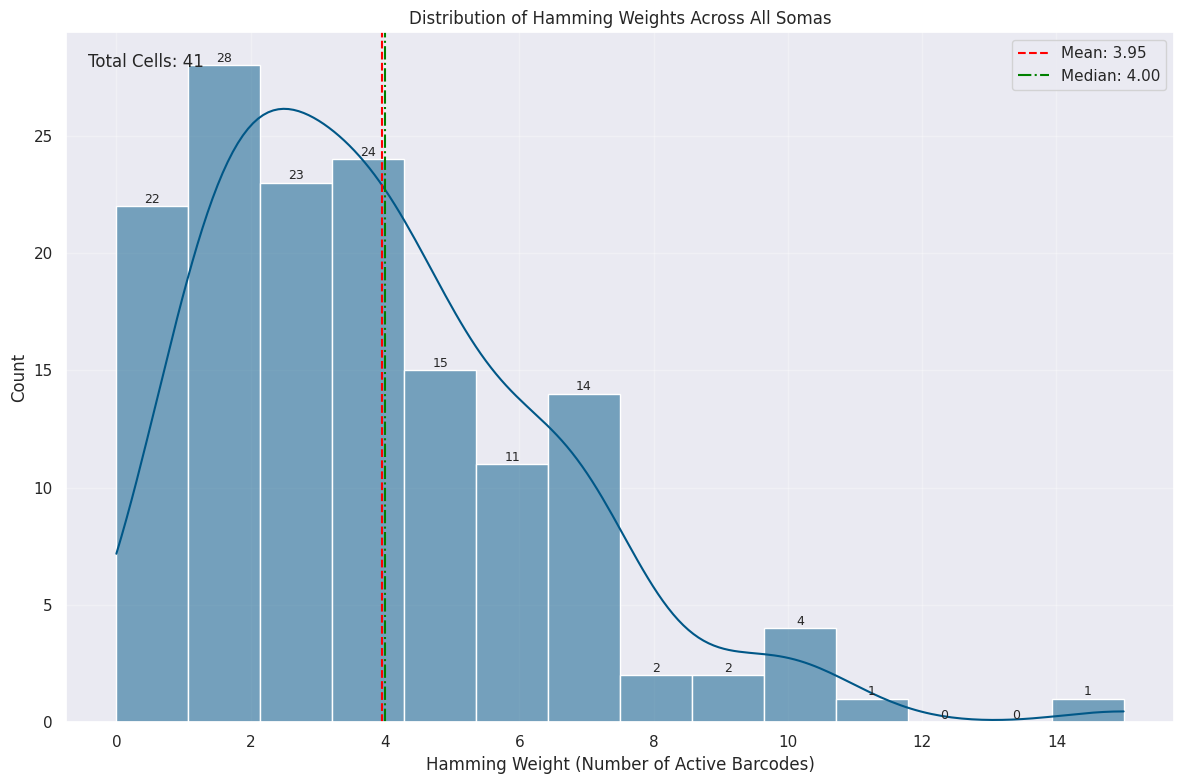

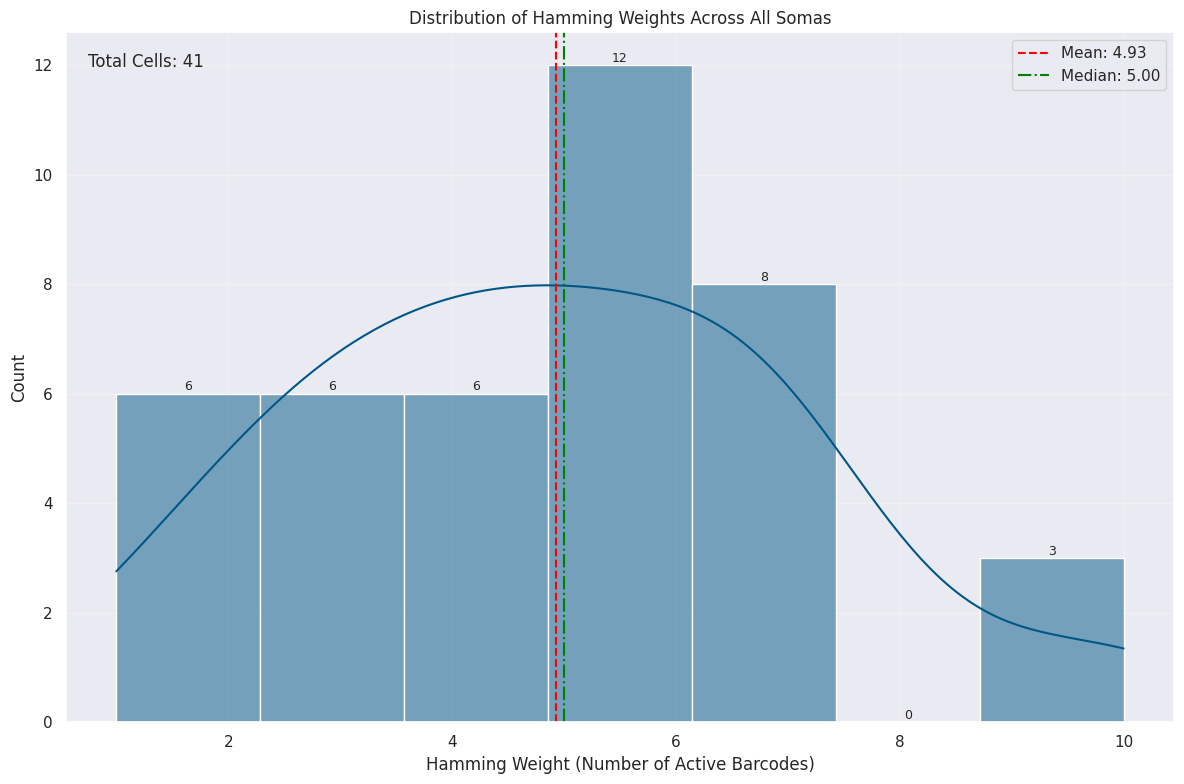

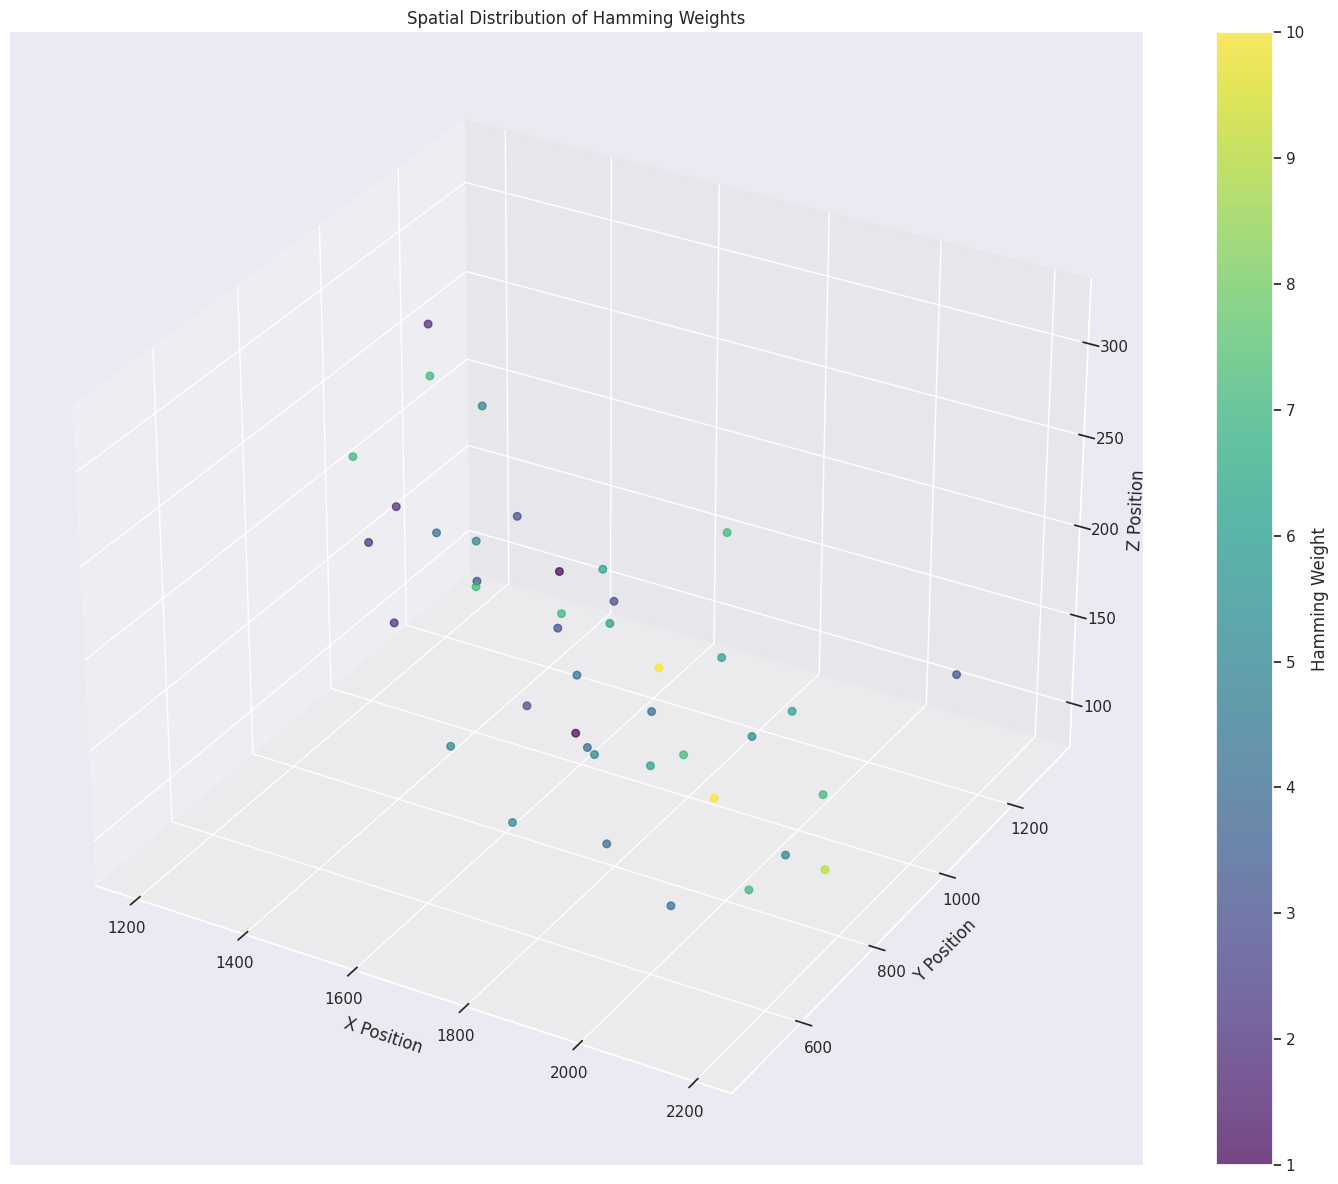

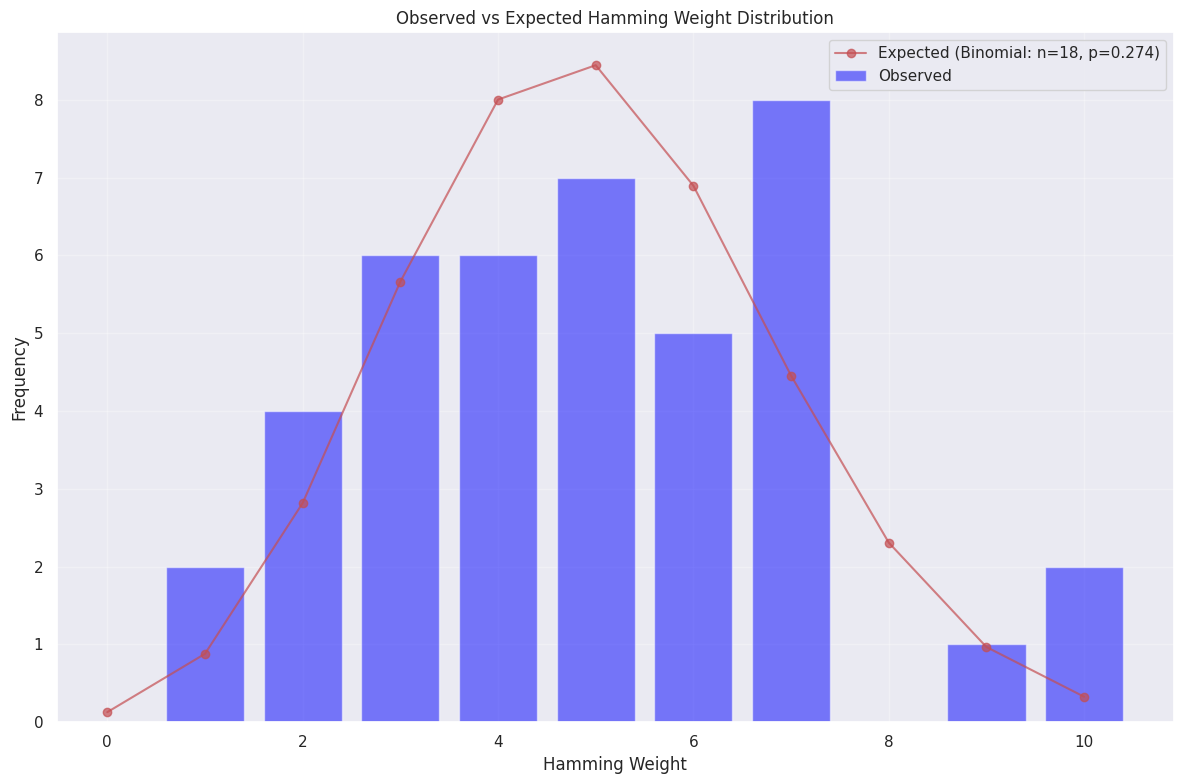

In [12]:
from hamming_weight_analysis import run_hamming_weight_analysis

# Run the complete analysis
weighted_df, stats = run_hamming_weight_analysis(filtered_df)

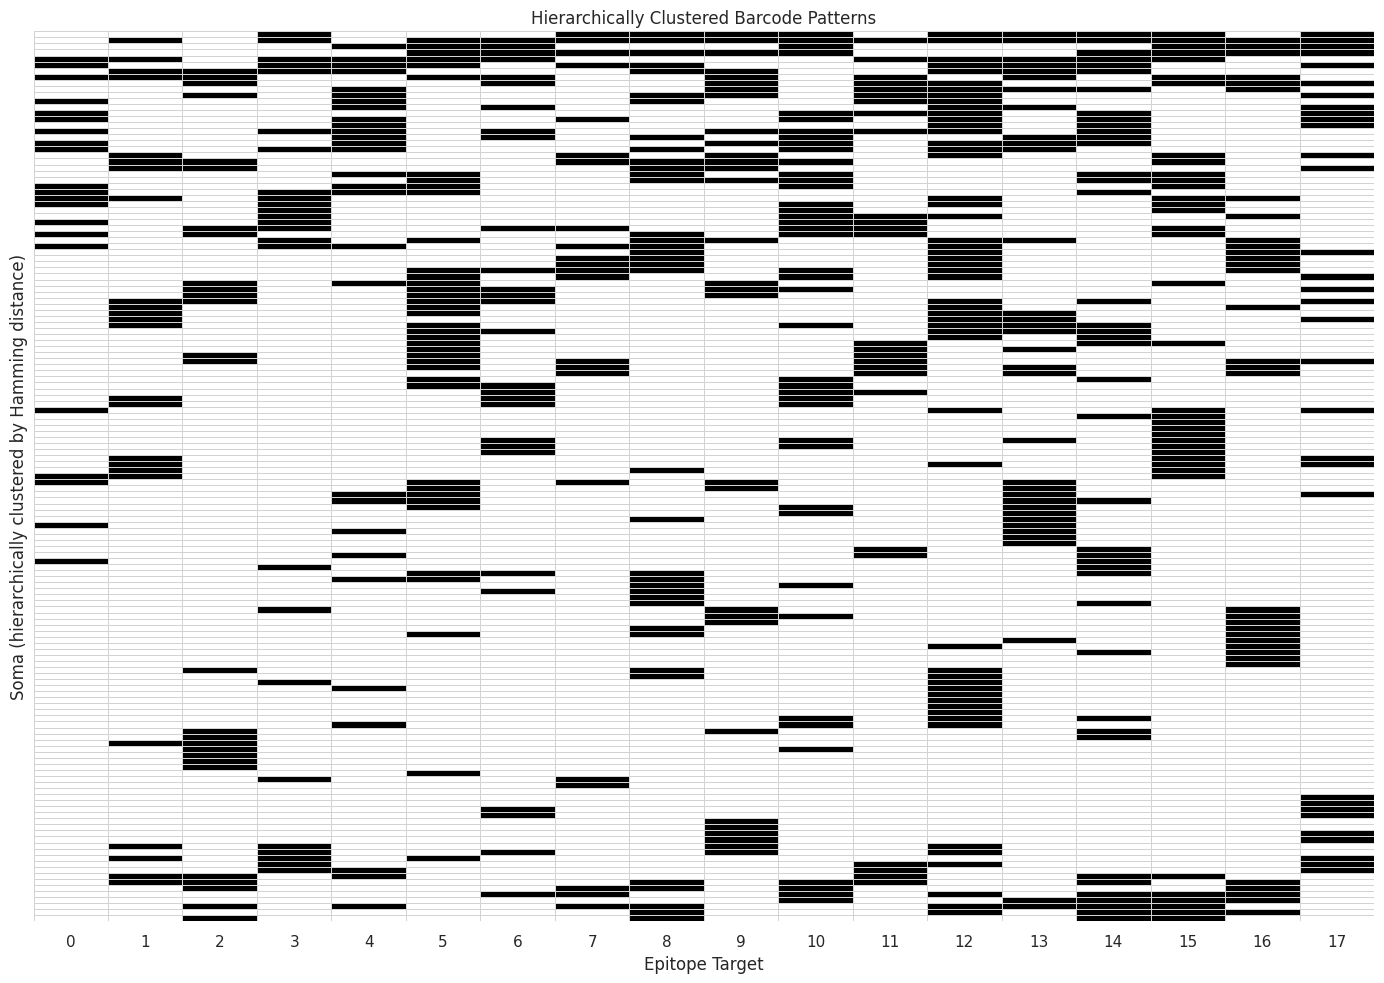

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

def plot_barcode_heatmaps(soma_barcodes, figsize_distance=(12, 10), figsize_barcodes=(14, 10)):
    """
    Generate hierarchically clustered heatmaps of barcode data.
    
    Parameters:
    -----------
    soma_barcodes : numpy array
        Binary matrix where each row is a soma/cell and each column is an epitope
    figsize_distance : tuple
        Figure size for the distance heatmap
    figsize_barcodes : tuple
        Figure size for the barcode pattern heatmap
    """
    # 1. Calculate Hamming distance between all pairs of barcodes
    hamming_dist = pdist(soma_barcodes, metric='hamming')
    hamming_dist_matrix = squareform(hamming_dist)
    
    # 2. Perform hierarchical clustering
    linkage = hierarchy.linkage(hamming_dist, method='average')
    dendro = hierarchy.dendrogram(linkage, no_plot=True)
    
    # 3. Get the reordering from clustering
    reordered_indices = dendro['leaves']

    
    # 5. Create the barcode pattern heatmap
    plt.figure(figsize=figsize_barcodes)
    reordered_barcodes = soma_barcodes[reordered_indices]
    ax = sns.heatmap(reordered_barcodes, 
                    cmap=['white', 'black'],  # Binary colormap for 0s and 1s
                    cbar=False, 
                    linewidths=0.5, 
                    linecolor='lightgray',
                    yticklabels=False)
    
    plt.title('Hierarchically Clustered Barcode Patterns')
    plt.xlabel('Epitope Target')
    plt.ylabel('Soma (hierarchically clustered by Hamming distance)')
    plt.tight_layout()
    plt.show()
    
    # Return the reordered indices in case they're needed for further analysis
    return reordered_indices

# Example usage:
# Assuming soma_barcodes is a numpy array with shape (n_cells, n_epitopes)
# containing binary values (0 and 1)
reordered_indices = plot_barcode_heatmaps(soma_barcodes)





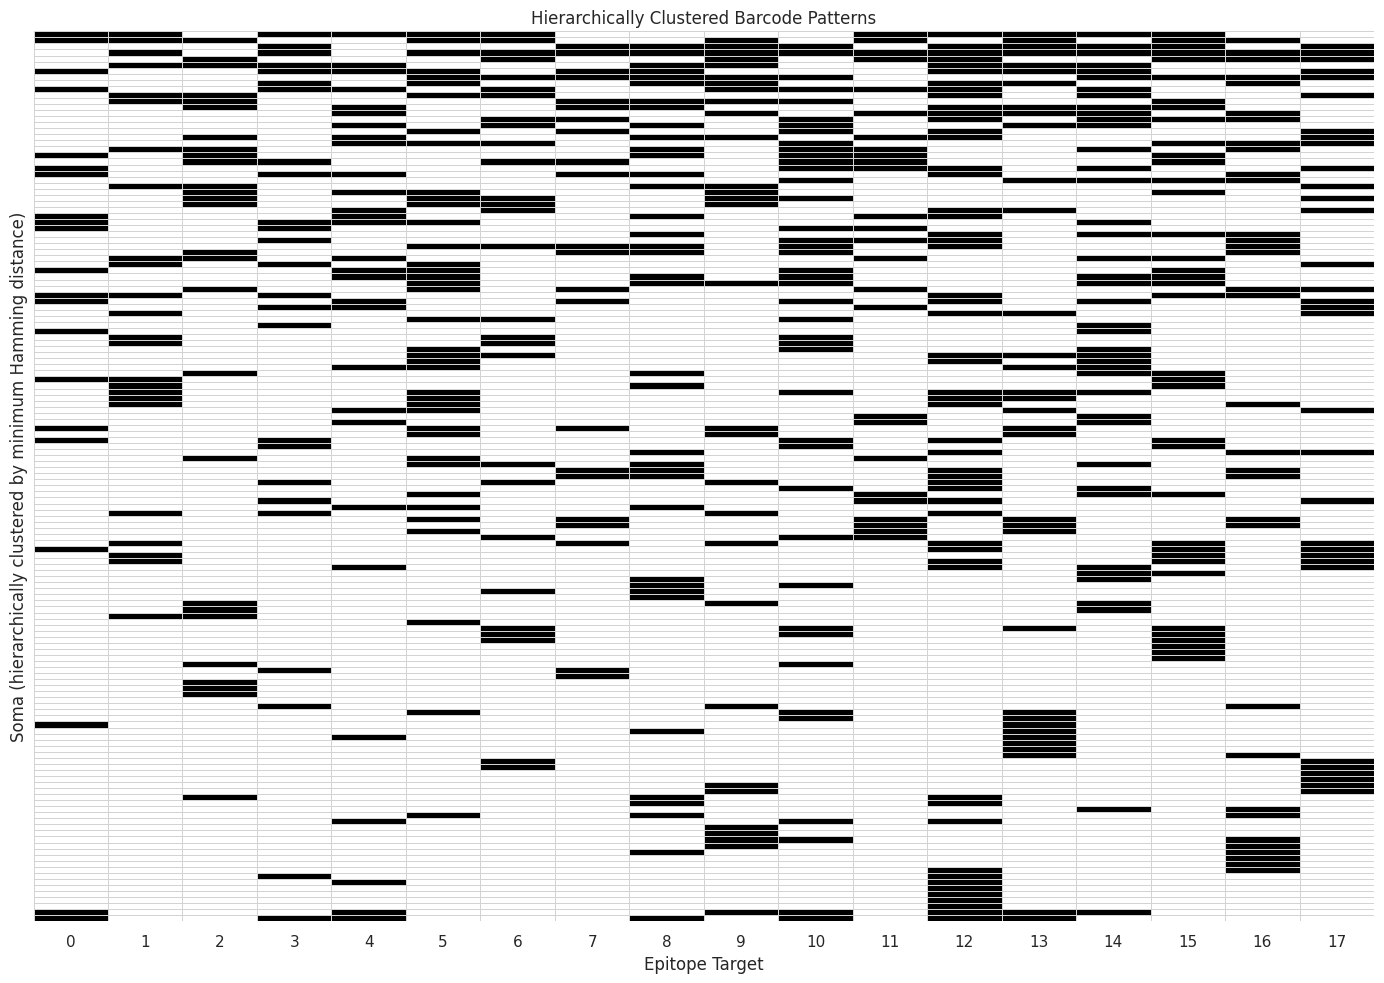

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

def plot_barcode_heatmaps(soma_barcodes, figsize_distance=(12, 10), figsize_barcodes=(14, 10)):
    """
    Generate hierarchically clustered heatmaps of barcode data.
    
    Parameters:
    -----------
    soma_barcodes : numpy array
        Binary matrix where each row is a soma/cell and each column is an epitope
    figsize_distance : tuple
        Figure size for the distance heatmap
    figsize_barcodes : tuple
        Figure size for the barcode pattern heatmap
    """
    # 1. Calculate Hamming distance between all pairs of barcodes
    hamming_dist = pdist(soma_barcodes, metric='hamming')
    hamming_dist_matrix = squareform(hamming_dist)
    
    # 2. Perform hierarchical clustering with single linkage (minimum distance)
    linkage = hierarchy.linkage(hamming_dist, method='single')
    dendro = hierarchy.dendrogram(linkage, no_plot=True)
    
    # 3. Get the reordering from clustering
    reordered_indices = dendro['leaves']
    
    # 4. Create the barcode pattern heatmap
    plt.figure(figsize=figsize_barcodes)
    reordered_barcodes = soma_barcodes[reordered_indices]
    ax = sns.heatmap(reordered_barcodes, 
                    cmap=['white', 'black'],  # Binary colormap for 0s and 1s
                    cbar=False, 
                    linewidths=0.5, 
                    linecolor='lightgray',
                    yticklabels=False)
    
    plt.title('Hierarchically Clustered Barcode Patterns')
    plt.xlabel('Epitope Target')
    plt.ylabel('Soma (hierarchically clustered by minimum Hamming distance)')
    plt.tight_layout()
    plt.show()
    
    # Return the reordered indices in case they're needed for further analysis
    return reordered_indices

# Example usage:
# Assuming soma_barcodes is a numpy array with shape (n_cells, n_epitopes)
# containing binary values (0 and 1)
reordered_indices = plot_barcode_heatmaps(soma_barcodes)

## Heat Map Analysis 

In [14]:
# heat map analysis of barcodes
soma_barcodes


array([[1, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], shape=(147, 18))

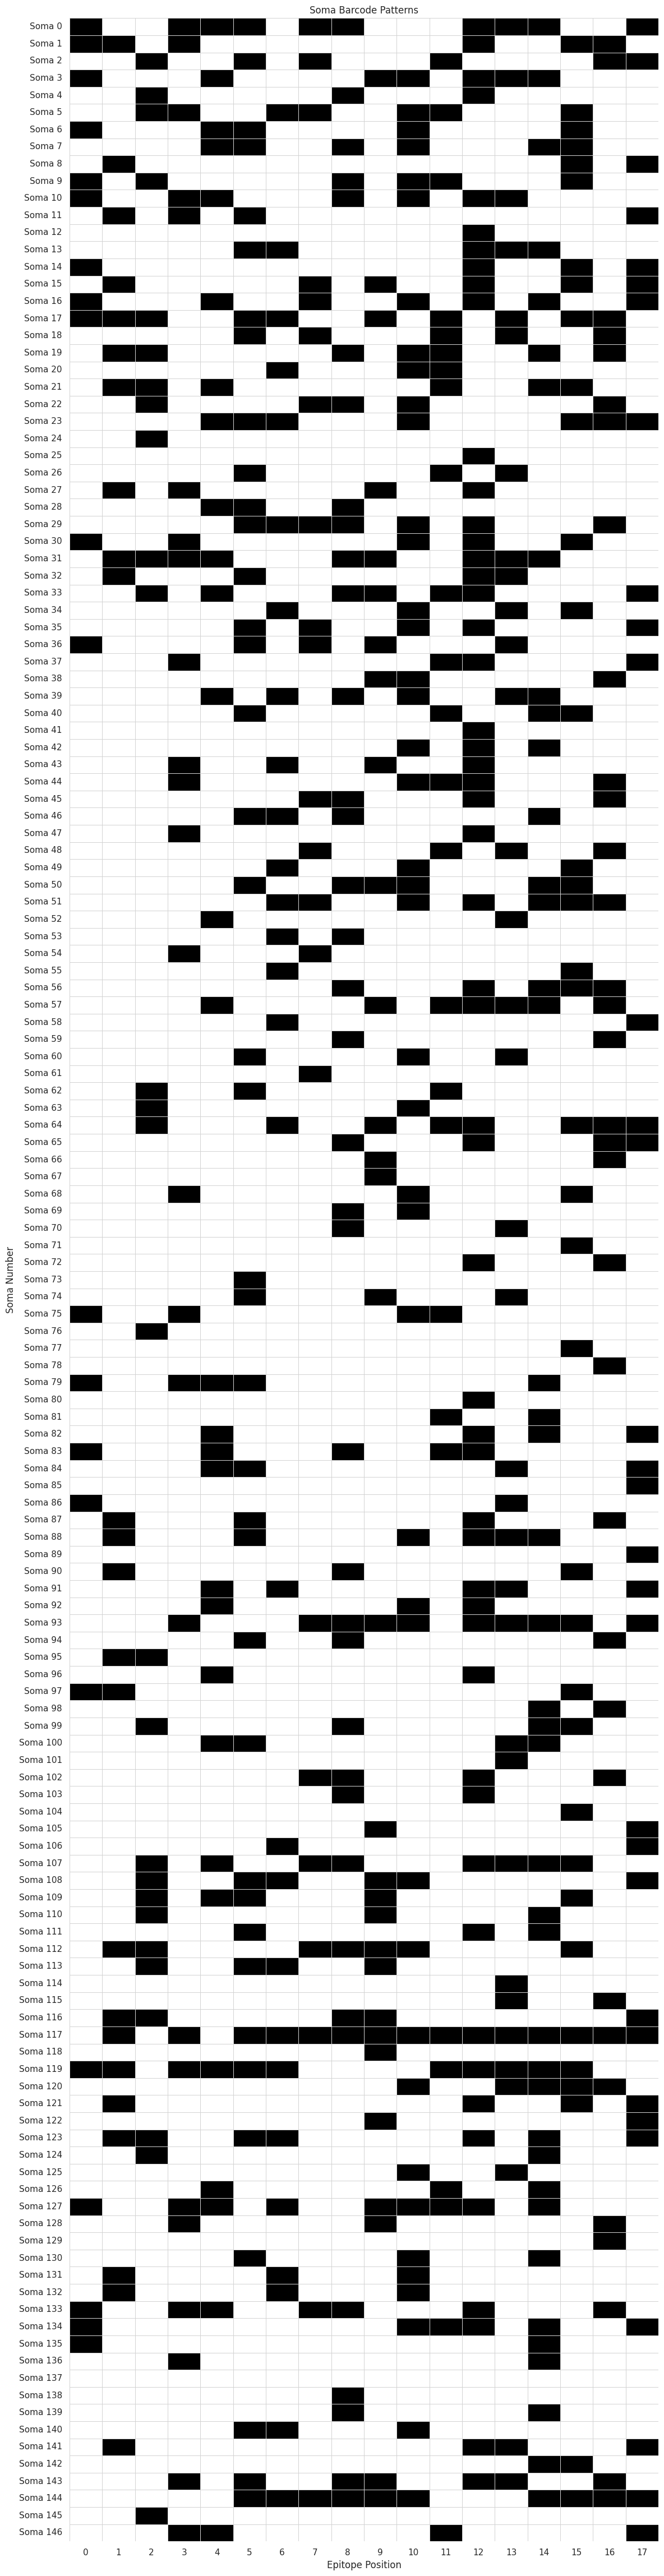

In [15]:
# visualize the barcode heat map with a grid of 74x18 somas

# Create a heatmap visualization of the soma barcodes
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# If your soma_barcodes is a list of lists, convert it to a numpy array
soma_barcodes_array = np.array(soma_barcodes)

# Create a figure with an appropriate size (adjust as needed)
plt.figure(figsize=(12, len(soma_barcodes_array) * 0.3 + 2))

# Create the heatmap with a binary colormap (white for 0, black for 1)
ax = sns.heatmap(soma_barcodes_array, cmap=['white', 'black'], 
                 cbar=False, linewidths=0.5, linecolor='lightgray')

# Set axis labels and title
plt.xlabel('Epitope Position')
plt.ylabel('Soma Number')
plt.title('Soma Barcode Patterns')

# Set y-ticks to show soma numbers
plt.yticks(np.arange(len(soma_barcodes_array)) + 0.5, 
           [f'Soma {i}' for i in range(len(soma_barcodes_array))], 
           rotation=0)

# Set x-ticks to show epitope positions
plt.xticks(np.arange(soma_barcodes_array.shape[1]) + 0.5, 
           np.arange(soma_barcodes_array.shape[1]), 
           rotation=0)

plt.tight_layout()
plt.show()